In [42]:
import math
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from Bio import SeqIO
from io import StringIO
import dendropy
from datetime import datetime
import re
import json
import itertools

from ete3 import Tree, TreeStyle, AttrFace, TextFace, RectFace, CircleFace, PieChartFace, ClusterTree, ProfileFace

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.patches import Ellipse
from matplotlib.colors import to_hex, ListedColormap
import seaborn as sns
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [43]:
def date2num(x):
    dt = datetime.strptime(x, '%Y-%m-%d')
    return int(dt.strftime('%Y')) + int(dt.strftime('%j')) / 365

def num2date(x):
    xs, zs = math.modf(float(x))
    day = round(xs * 365)
    dt = datetime.strptime(f'{int(zs)}.{day}', '%Y.%j')
    return dt.strftime('%Y-%m-%d')

In [44]:
beast_map = {'1_1_1_1_1_1_1_1': {'PB2':'1_1_1_1_1_1_1_1', 'PB1':'1_1_1_1_1_1_1_1', 'PA':'1_1_1_1_1_1_1_1', 'HA':'1_1_1_1_1_1_1_1', 'NP':'1_1_1_1_1_1_1_1', 'NA':'1_1_1_1_1_1_1_1', 'MP':'1_1_1_1_1_1_1_1', 'NS':'1_1_1_1_1_1_1_1', },
 '0_0_0_0_0_0_0_0': {'PB2':'0_0_0_0_0_0_0_0', 'PB1':'0_0_0_0_0_0_0_0', 'PA':'0_0_0_0_0_0_0_0', 'HA':'0_0_0_0_0_0_0_0', 'NP':'0_0_0_0_0_0_0_0', 'NA':'0_0_0_0_0_0_0_0', 'MP':'0_0_0_0_0_0_0_0', 'NS':'0_0_0_0_0_0_0_0', },
 '4_2_3_0_3_2_0_0': {'PB2':'4_2_3_0_3_2_0_0', 'PB1':'4_2_3_0_3_2_0_0', 'PA':'4_2_3_0_3_2_0_0', 'HA':'0_0_0_0_0_0_0_0', 'NP':'4_2_3_0_3_2_0_0', 'NA':'4_2_3_0_3_2_0_0', 'MP':'0_0_0_0_0_0_0_0', 'NS':'0_0_0_0_0_0_0_0', },
 '2_2_1_1_2_1_1_1': {'PB2':'2_2_1_1_2_1_1_1', 'PB1':'2_2_1_1_2_1_1_1', 'PA':'1_1_1_1_1_1_1_1', 'HA':'1_1_1_1_1_1_1_1', 'NP':'2_2_1_1_2_1_1_1', 'NA':'1_1_1_1_1_1_1_1', 'MP':'1_1_1_1_1_1_1_1', 'NS':'1_1_1_1_1_1_1_1', },
 '3_2_2_1_2_1_1_2': {'PB2':'3_2_2_1_2_1_1_2', 'PB1':'2_2_1_1_2_1_1_1', 'PA':'3_2_2_1_2_1_1_2', 'HA':'1_1_1_1_1_1_1_1', 'NP':'2_2_1_1_2_1_1_1', 'NA':'1_1_1_1_1_1_1_1', 'MP':'1_1_1_1_1_1_1_1', 'NS':'3_2_2_1_2_1_1_2', },
 '1_1_1_1_2_1_1_1': {'PB2':'1_1_1_1_1_1_1_1', 'PB1':'1_1_1_1_1_1_1_1', 'PA':'1_1_1_1_1_1_1_1', 'HA':'1_1_1_1_1_1_1_1', 'NP':'2_2_1_1_2_1_1_1', 'NA':'1_1_1_1_1_1_1_1', 'MP':'1_1_1_1_1_1_1_1', 'NS':'1_1_1_1_1_1_1_1', }}

host_l = ['Waterfowl', 'Dom-ans', 'Dom-gal', 'Wild-gal', 'Seabird', 'Other']
color_seg = ['#BC3C29', '#0072B5', '#E18727', '#20854E', '#7876B1', '#FFDC91', '#EE4C97', '#6F99AD']
color_host = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, len(host_l)))
host_cmap = {k: to_hex(v) for k, v in zip(host_l, color_host)}
seg_l = ['PB2', 'PB1', 'PA', 'HA', 'NP', 'NA', 'MP', 'NS']
domain_group = ['1_1_1_1_1_1_1_1', '0_0_0_0_0_0_0_0', '4_2_3_0_3_2_0_0', '2_2_1_1_2_1_1_1', '3_2_2_1_2_1_1_2', '1_1_1_1_2_1_1_1']


# Read metadata

In [74]:
genotype = pd.read_csv('genotype.csv', sep='\t', index_col=9)
metainfo = pd.read_csv('dataset2_metainfo.csv', sep='\t')
metainfo = metainfo.set_index('Isolate_Id')

In [75]:
group_map = {
    '1_1_1_1_1_1_1_1': 'G1noR', '2_2_1_1_2_1_1_1': 'G1R1', '3_2_2_1_2_1_1_2': 'G1R2', '1_1_1_1_2_1_1_1': 'G1R3', '3_5_1_1_2_1_1_1': 'G1other', '3_1_2_1_2_1_1_1': 'G1other', 
    '0_0_0_0_0_0_0_0': 'G0noR', '4_2_3_0_3_2_0_0': 'G0R1', '0_0_5_0_0_0_0_0': 'G0other', '5_4_4_0_4_0_3_3': 'G0other', '6_3_6_0_5_0_2_4': 'G0other'
}

In [76]:
metainfo = metainfo.join(genotype['group'])

In [77]:
metainfo['group2'] = metainfo['group'].map(group_map)

In [78]:
metainfo

Isolate_Name    Subtype  \
Isolate_Id                                                                
EPI_ISL_331295                         A/teal/Chany/324/2017  A / H12N5   
EPI_ISL_331289                  A/mallard/Dagestan/1050/2018   A / H7N3   
EPI_ISL_331290                  A/mallard/Dagestan/1051/2018   A / H7N3   
EPI_ISL_362150   A/Chicken/Netherlands/17014215-026-030/2017   A / H5N2   
EPI_ISL_394155    A/chicken/Netherlands/17013178-006010/2017  A / H10N7   
...                                                      ...        ...   
EPI_ISL_644127                        A/goose/Omsk/0113/2020   A / H5N8   
EPI_ISL_644125                        A/goose/Omsk/0111/2020   A / H5N8   
EPI_ISL_644143                         A/duck/Omsk/0076/2020   A / H5N8   
EPI_ISL_1114759           A/turkey/Rostov-on-Don/332-12/2021   A / H5N8   
EPI_ISL_1114756           A/turkey/Rostov-on-Don/332-08/2021   A / H5N8   

                                            Host  \
Isolate_Id                                         
EPI_ISL_331295                             Avian   
EPI_ISL_331289                             Avian   
EPI_ISL_331290                             Avian   
EPI_ISL_362150          Gallus gallus domesticus   
EPI_ISL_394155          Gallus gallus domesticus   
...                                          ...   
EPI_ISL_644127            Anser anser domesticus   
EPI_ISL_644125            Anser anser domesticus   
EPI_ISL_644143   Anas platyrhynchos f. domestica   
EPI_ISL_1114759              Meleagris gallopavo   
EPI_ISL_1114756              Meleagris gallopavo   

                                                          Location  \
Isolate_Id                                                           
EPI_ISL_331295            Europe / Russian Federation / Chany Lake   
EPI_ISL_331289   Europe / Russian Federation / Republic of Dage...   
EPI_ISL_331290   Europe / Russian Federation / Republic of Dage...   
EPI_ISL_362150   Europe / Netherlands / Provincie Zeeland / Sin...   
EPI_ISL_394155          Europe / Netherlands / Provincie Friesland   
...                                                            ...   
EPI_ISL_644127    Europe / Russian Federation / Omsk Oblast / Omsk   
EPI_ISL_644125    Europe / Russian Federation / Omsk Oblast / Omsk   
EPI_ISL_644143    Europe / Russian Federation / Omsk Oblast / Omsk   
EPI_ISL_1114759  Europe / Russian Federation / Rostov Oblast / ...   
EPI_ISL_1114756  Europe / Russian Federation / Rostov Oblast / ...   

                Collection_Date Domestic_Status     host  Region  \
Isolate_Id                                                         
EPI_ISL_331295       2017-09-03            Wild     teal  Europe   
EPI_ISL_331289       2018-01-23             NaN  mallard  Europe   
EPI_ISL_331290       2018-01-23             NaN  mallard  Europe   
EPI_ISL_362150       2017-10-13             NaN  Chicken  Europe   
EPI_ISL_394155       2017-09-27        Domestic  chicken  Europe   
...                         ...             ...      ...     ...   
EPI_ISL_644127       2020-08-17        Domestic    goose  Europe   
EPI_ISL_644125       2020-08-17        Domestic    goose  Europe   
EPI_ISL_644143       2020-08-17        Domestic     duck  Europe   
EPI_ISL_1114759      2021-01-29             NaN   turkey  Europe   
EPI_ISL_1114756      2021-01-29             NaN   turkey  Europe   

                            Country              Province    Subregion  \
Isolate_Id                                                               
EPI_ISL_331295   Russian Federation            Chany Lake   North_Asia   
EPI_ISL_331289   Russian Federation  Republic of Dagestan  East_Europe   
EPI_ISL_331290   Russian Federation  Republic of Dagestan  East_Europe   
EPI_ISL_362150          Netherlands     Provincie Zeeland  West_Europe   
EPI_ISL_394155          Netherlands   Provincie Friesland  West_Europe   
...                             ...                   ...          ...   
EPI_ISL

In [50]:
# metainfo.to_csv('strains_included.csv')

# Location estimation

In [51]:
def unifyAnno(matched):
    a, b = matched.group(1), matched.group(2)
    return f"{b}{a}"

def parseAnno(matched):
    a = matched.group(0)[1:-1]
    return f"[&&NHX:node={a}]"

def extractPosteriorTrees(acc_in_group, path):
    test = json.load(open(path))
    d = pd.DataFrame(test['data'])
    d = d.set_index('edge_num')
    s = test['tree']
    s2 = re.sub("({\d+})(e-\d+)", unifyAnno, s)
    s3 = re.sub("\{(.*?)\}", parseAnno, s2)

    tree = Tree(s3)
    tree.ladderize(1)

    acc_in_tree = tree.get_leaf_names()
    acc_l = [acc for acc in acc_in_tree if acc in acc_in_group]

    if len(acc_l) == 0:
        raise ValueError('Make sure with quite group')
    elif len(acc_l) == 1:
        mrca = (tree&acc_l[0]).up
    else:
        mrca = tree.get_common_ancestor(acc_l)

    root = tree.get_tree_root()

    node_num = int(mrca.node)
    loc1, loc2 = d.loc[node_num, 'loc']
    height1 = tree.get_distance(root, mrca)

    mrcga = mrca.up
    node_num = int(mrcga.node)
    loc3, loc4 = d.loc[node_num, 'loc']
    height2 = tree.get_distance(root, mrcga)
    
    return loc1, loc2, loc3, loc4, height1, height2

In [52]:
def draw_single_seg_map(ax, seg, values, color, extent=(-20, 160, -30, 90), step=(30, 30)):
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), lw=0.3)
    ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
    ax.set_xticks(np.arange(extent[0], extent[1] + step[0], step[0]),crs=proj)
    ax.set_yticks(np.arange(extent[2], extent[3] + step[1], step[1]), crs=proj)

    # 利用Formatter格式化刻度标签
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    plt.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_extent(extent, crs=proj)
    ax.set_title(seg, fontsize=6)

    loc_array = np.array(values)
    loc_median = np.median(loc_array, axis=0)
    loc1, loc2, loc3, loc4, *_ = loc_median

    sns.kdeplot(x=loc_array[:,1], y=loc_array[:,0], fill=True, color=color, thresh=0.2, ax=ax, transform=proj, alpha=0.6)
    sns.kdeplot(x=loc_array[:,3], y=loc_array[:,2], fill=False, color=color, levels=np.array([0.2, 1]), ax=ax, transform=proj, alpha=0.8)
    ax.annotate('', (loc2, loc1), (loc4, loc3), transform=proj, arrowprops=dict(arrowstyle='fancy', connectionstyle="arc3,rad=0.2", color=color, alpha=0.8, shrinkB=5, linewidth=0.5))


In [53]:
def draw_multiple_seg_map(ax, group, values, extent=(-20, 160, -30, 90)):
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), lw=0.3)
    ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
    # ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), edgecolor='white', lw=0)
    ax.add_feature(cfeature.RIVERS.with_scale('50m'), lw=.4)
    # ax.add_feature(cfeature.BORDERS, edgecolor='grey')

    ax.set_xticks(np.arange(extent[0], extent[1] + 30, 30), crs=proj)
    ax.set_xticks(np.arange(extent[0], extent[1] + 15, 15), minor=True, crs=proj)
    ax.set_yticks(np.arange(extent[2], extent[3] + 30, 30), crs=proj)
    ax.set_yticks(np.arange(extent[2], extent[3] + 15, 15), minor=True, crs=proj)
    # 利用Formatter格式化刻度标签
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    plt.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_extent((-20, 160, -20, 90), crs=proj)
    ax.set_title(f'Most Recent Common Ancestor Estimation\n for Group {group}', style='italic', weight='bold', fontsize=8)


    for i, seg in enumerate(seg_l):
        loc_array = np.array(values[seg])
        loc_median = np.median(loc_array, axis=0)
        loc1, loc2, loc3, loc4, height1, height2 = loc_median

        sns.kdeplot(x=loc_array[:,1], y=loc_array[:,0], fill=True, color=color_seg[i], thresh=0.2, ax=ax, transform=proj, alpha=0.6)
        sns.kdeplot(x=loc_array[:,3], y=loc_array[:,2], fill=False, color=color_seg[i], levels=np.array([0.2, 1]), ax=ax, transform=proj, alpha=0.4)
        ax.annotate('', (loc2, loc1), (loc4, loc3), transform=proj, arrowprops=dict(arrowstyle='fancy', connectionstyle="arc3,rad=0.2", color=color_seg[i], alpha=0.6, shrinkB=5))

    import matplotlib.patches as mpatches
    ha = []
    for color, seg in zip(color_seg, ['PB2', 'PB1', 'PA', 'HA', 'NP', 'NA', 'MP', 'NS']):
        ha.append(mpatches.Patch(color=color, label=seg, alpha=0.6))
    plt.legend(handles=ha, frameon=False, loc='lower right', fontsize=4)



In [54]:
loc_dict1 = {}
for seg in seg_l:
    group = domain_group[1]
    acc_in_group = genotype.query('group == @group').index.to_list()
    loc_dict1[seg] = [extractPosteriorTrees(acc_in_group, f'./data/03_beast_analysis/group00000000/extractions{seg}/tree{i}.jtree') for i in range(1, 301)]

loc_dict2 = {}
for seg in seg_l:
    group = domain_group[0]
    acc_in_group = genotype.query('group == @group').index.to_list()
    loc_dict2[seg] = [extractPosteriorTrees(acc_in_group, f'./data/03_beast_analysis/group11111111/extractions{seg}/tree{i}.jtree') for i in range(1, 301)]

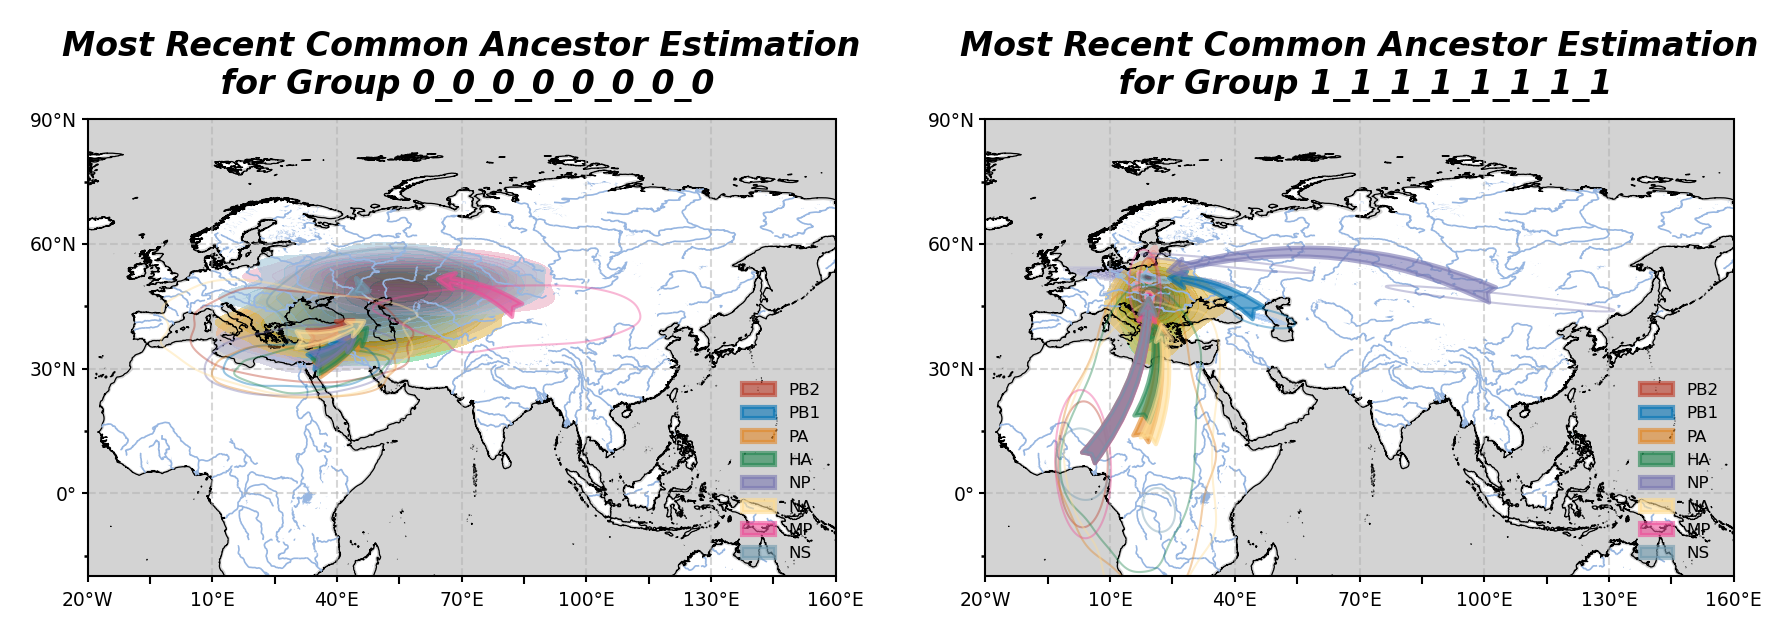

In [55]:
fig = plt.figure(figsize=(7.08, 3), dpi=300)
proj = ccrs.PlateCarree()

ax = fig.add_subplot(121, projection=proj)
draw_multiple_seg_map(ax, '0_0_0_0_0_0_0_0', loc_dict1)

ax = fig.add_subplot(122, projection=proj)
draw_multiple_seg_map(ax, '1_1_1_1_1_1_1_1', loc_dict2)

plt.show()

In [14]:
plt.rcParams['figure.facecolor'] = '#FFFFFF'
plt.rcParams['figure.dpi'] = 300

plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['axes.linewidth'] = 0.5

plt.rcParams['xtick.labelsize'] = 4.5
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['xtick.major.pad'] = 2

plt.rcParams['ytick.labelsize'] = 4.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.minor.size'] = 1
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.major.pad'] = 1


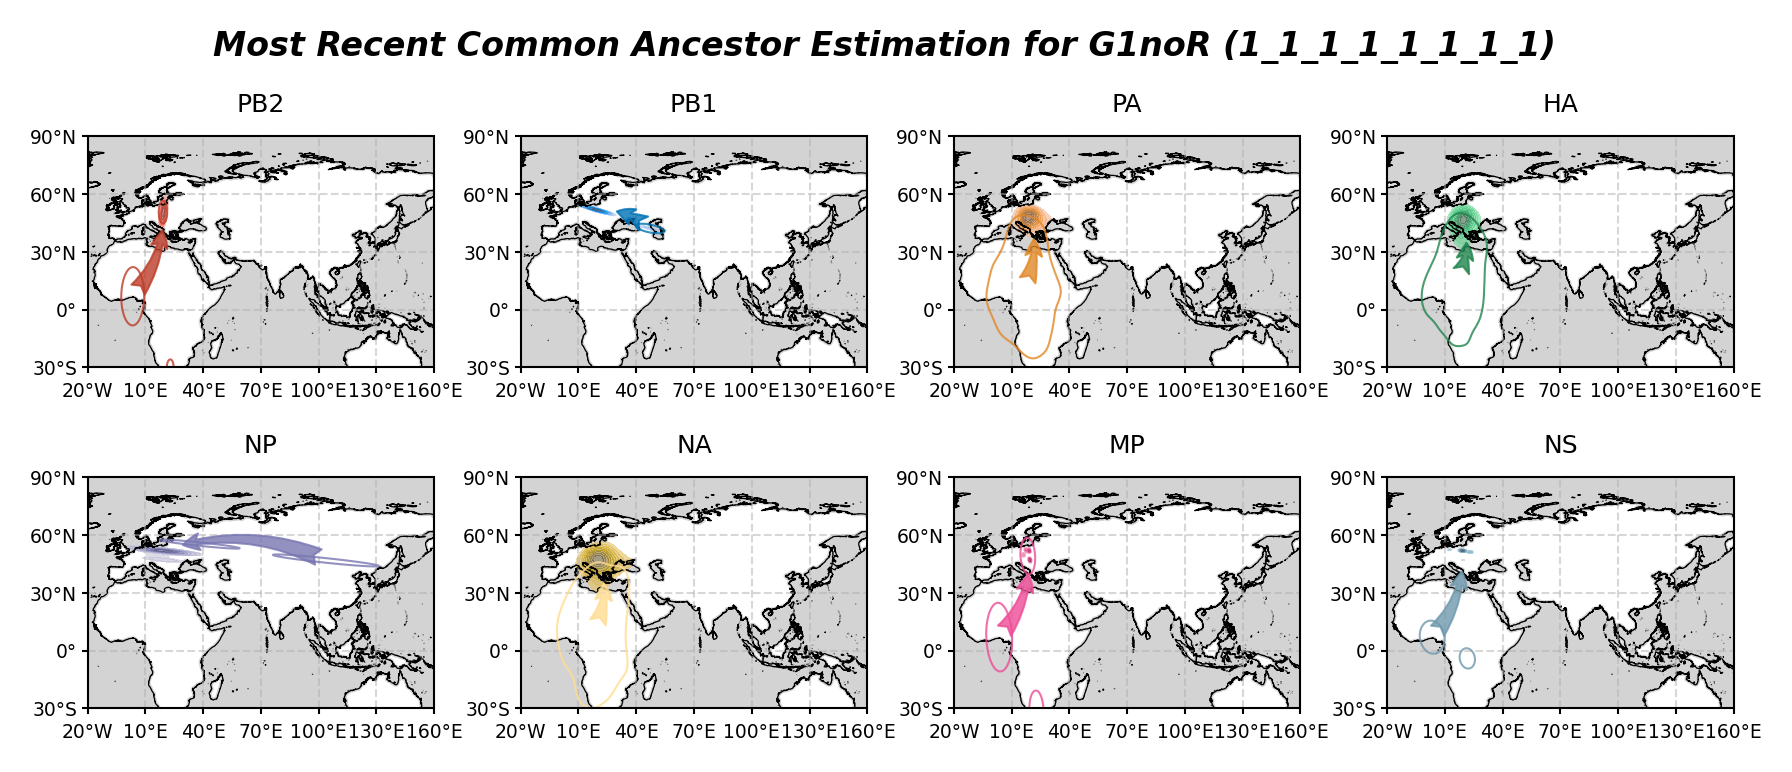

In [19]:
fig = plt.figure(figsize=(7.08, 2.8))
proj = ccrs.PlateCarree()
for i, seg in enumerate(seg_l):
    ax = fig.add_subplot(2, 4, i+1, projection=proj)
    draw_single_seg_map(ax, seg, loc_dict2[seg], color_seg[i], extent=(-20, 160, -30, 90), step=(30, 30))

plt.subplots_adjust(hspace=0.1, top=0.9, wspace=0.25)
fig.suptitle('Most Recent Common Ancestor Estimation for G1noR (1_1_1_1_1_1_1_1)', style='italic', weight='bold', fontsize=8)
plt.show()

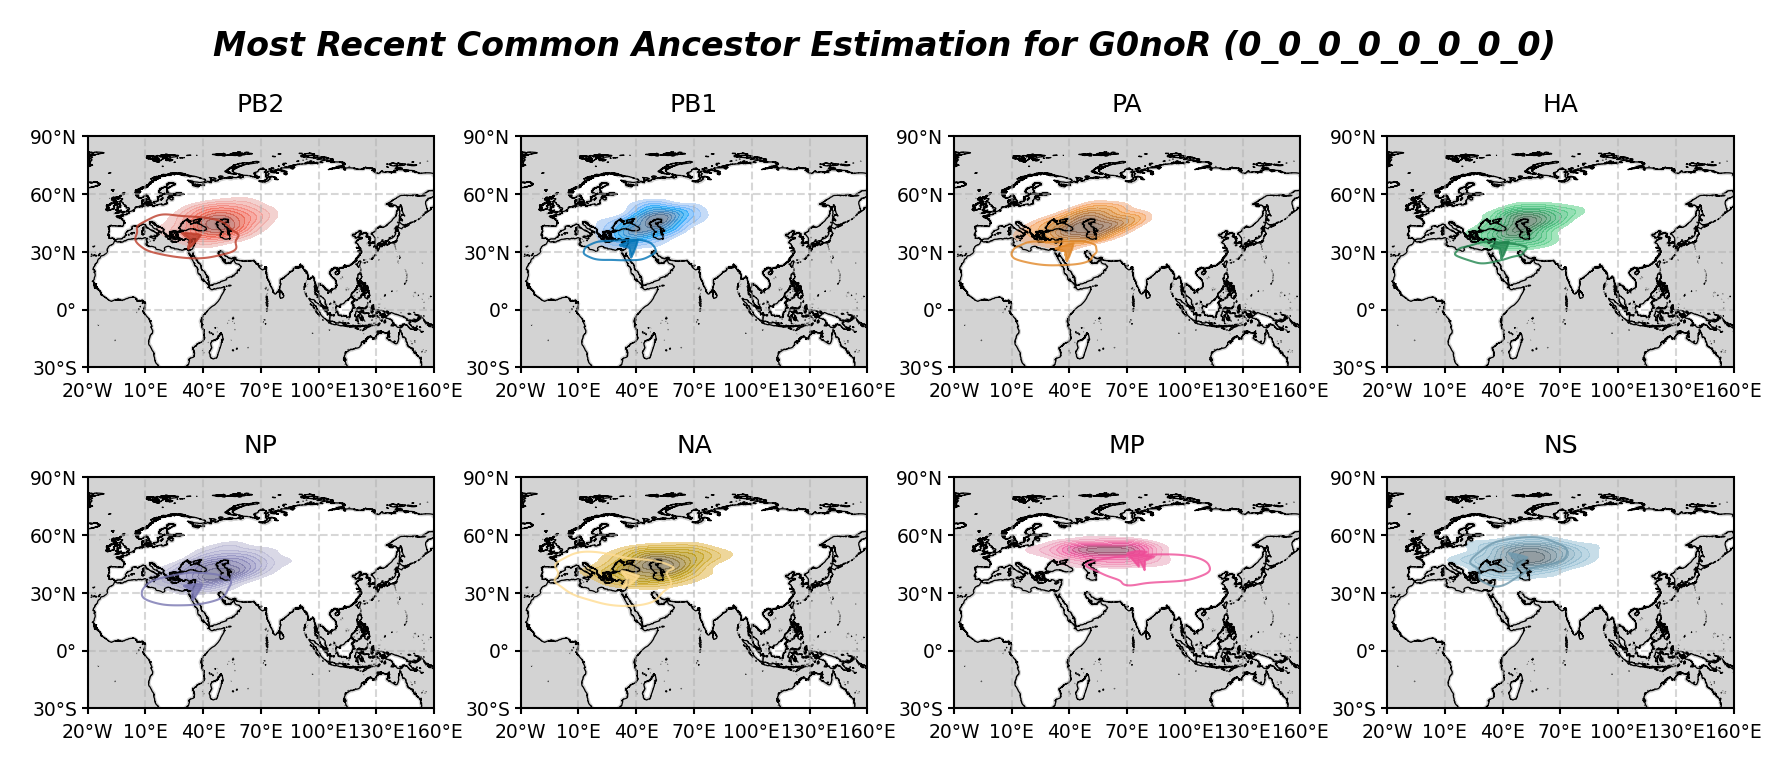

In [20]:
fig = plt.figure(figsize=(7.08, 2.8))
proj = ccrs.PlateCarree()
for i, seg in enumerate(seg_l):
    ax = fig.add_subplot(2, 4, i+1, projection=proj)
    draw_single_seg_map(ax, seg, loc_dict1[seg], color_seg[i], extent=(-20, 160, -30, 90), step=(30, 30))

plt.subplots_adjust(hspace=0.1, top=0.9, wspace=0.25)
fig.suptitle('Most Recent Common Ancestor Estimation for G0noR (0_0_0_0_0_0_0_0)', style='italic', weight='bold', fontsize=8)
plt.show()

# extract MCAR time distribution form Tree posterior distribution

In [237]:
def unifyAnno(matched):
    a, b = matched.group(1), matched.group(2)
    return f"{b}{a}"

def parseAnno(matched):
    a = matched.group(0)[1:-1]
    return f"[&&NHX:node={a}]"

def extractPosteriorTrees(group, path):
    test = json.load(open(path))
    d = pd.DataFrame(test['data'])
    d = d.set_index('edge_num')
    s = test['tree']
    s2 = re.sub("({\d+})(e-\d+)", unifyAnno, s)
    s3 = re.sub("\{(.*?)\}", parseAnno, s2)

    tree = Tree(s3)
    tree.ladderize(1)

    node, depth= tree.get_farthest_leaf()
    most_recent_sample_date = metainfo.loc[node.name, 'Collection_Date']
    most_recent_sample_date_num = date2num(most_recent_sample_date)

    acc_in_group = genotype.query('group == @group').index.tolist()
    acc_in_tree = tree.get_leaf_names()
    acc_l = [acc for acc in acc_in_tree if acc in acc_in_group]

    if len(acc_l) == 0:
        raise ValueError('Make sure with quite group')
    elif len(acc_l) == 1:
        mrca = (tree&acc_l[0]).up
    else:
        mrca = tree.get_common_ancestor(acc_l)

    root = tree.get_tree_root()

    node_num = int(mrca.node)
    loc1, loc2 = d.loc[node_num, 'loc']
    height1 = most_recent_sample_date_num - tree.get_distance(root, mrca)

    mrcga = mrca.up
    node_num = int(mrcga.node)
    loc3, loc4 = d.loc[node_num, 'loc']
    height2 = most_recent_sample_date_num - tree.get_distance(root, mrcga)
    
    return loc1, loc2, loc3, loc4, height1, height2

seg = 'MP'
test = [extractPosteriorTrees(domain_group[2], f'./data/03_beast_analysis/group00000000/extractions{seg}/tree{i}.jtree') for i in range(1, 301)]


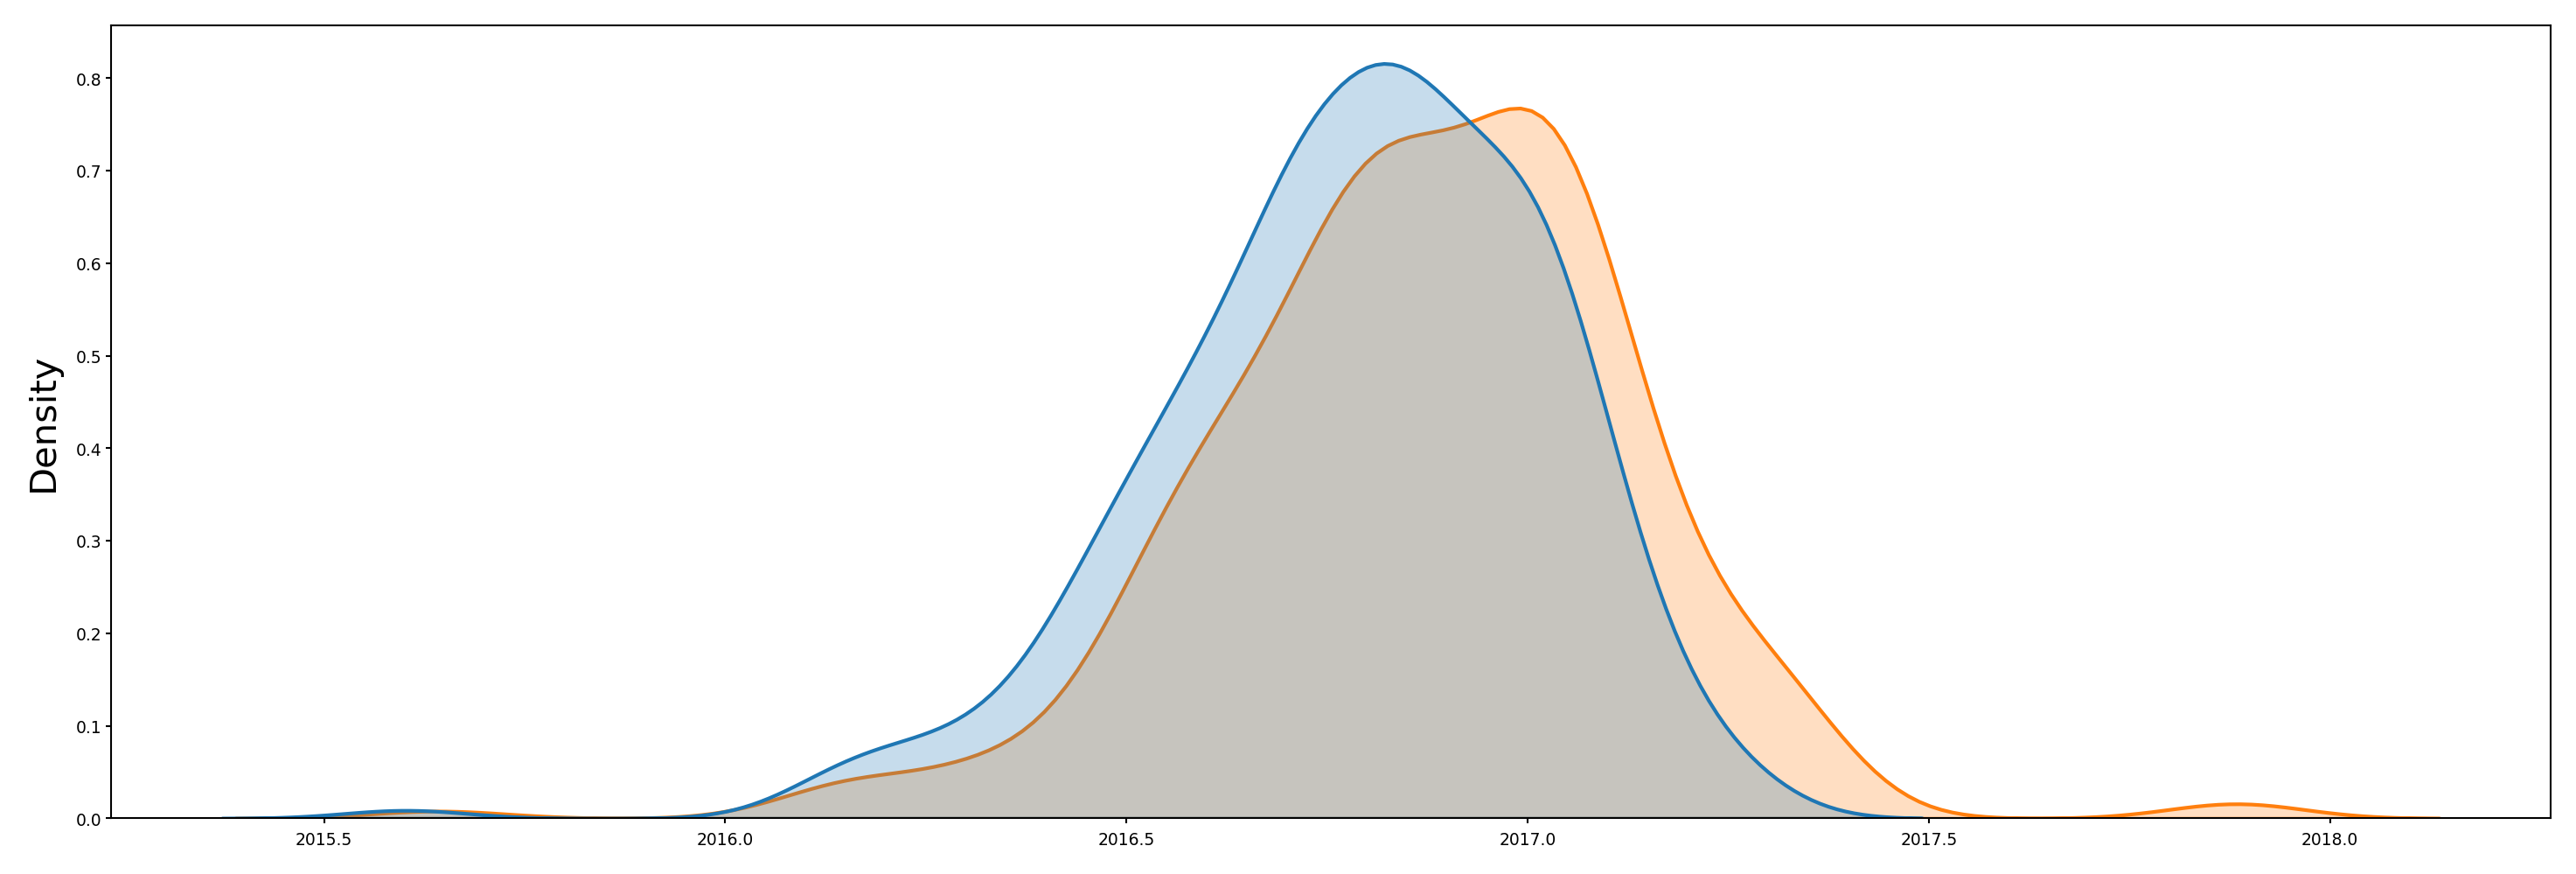

In [238]:
f = plt.figure(figsize=(12, 4))

ax = f.add_subplot(111)
tmp = pd.DataFrame(test).iloc[:, 4:6]
sns.kdeplot(data=tmp, ax=ax, legend=False, fill=True)
plt.show()

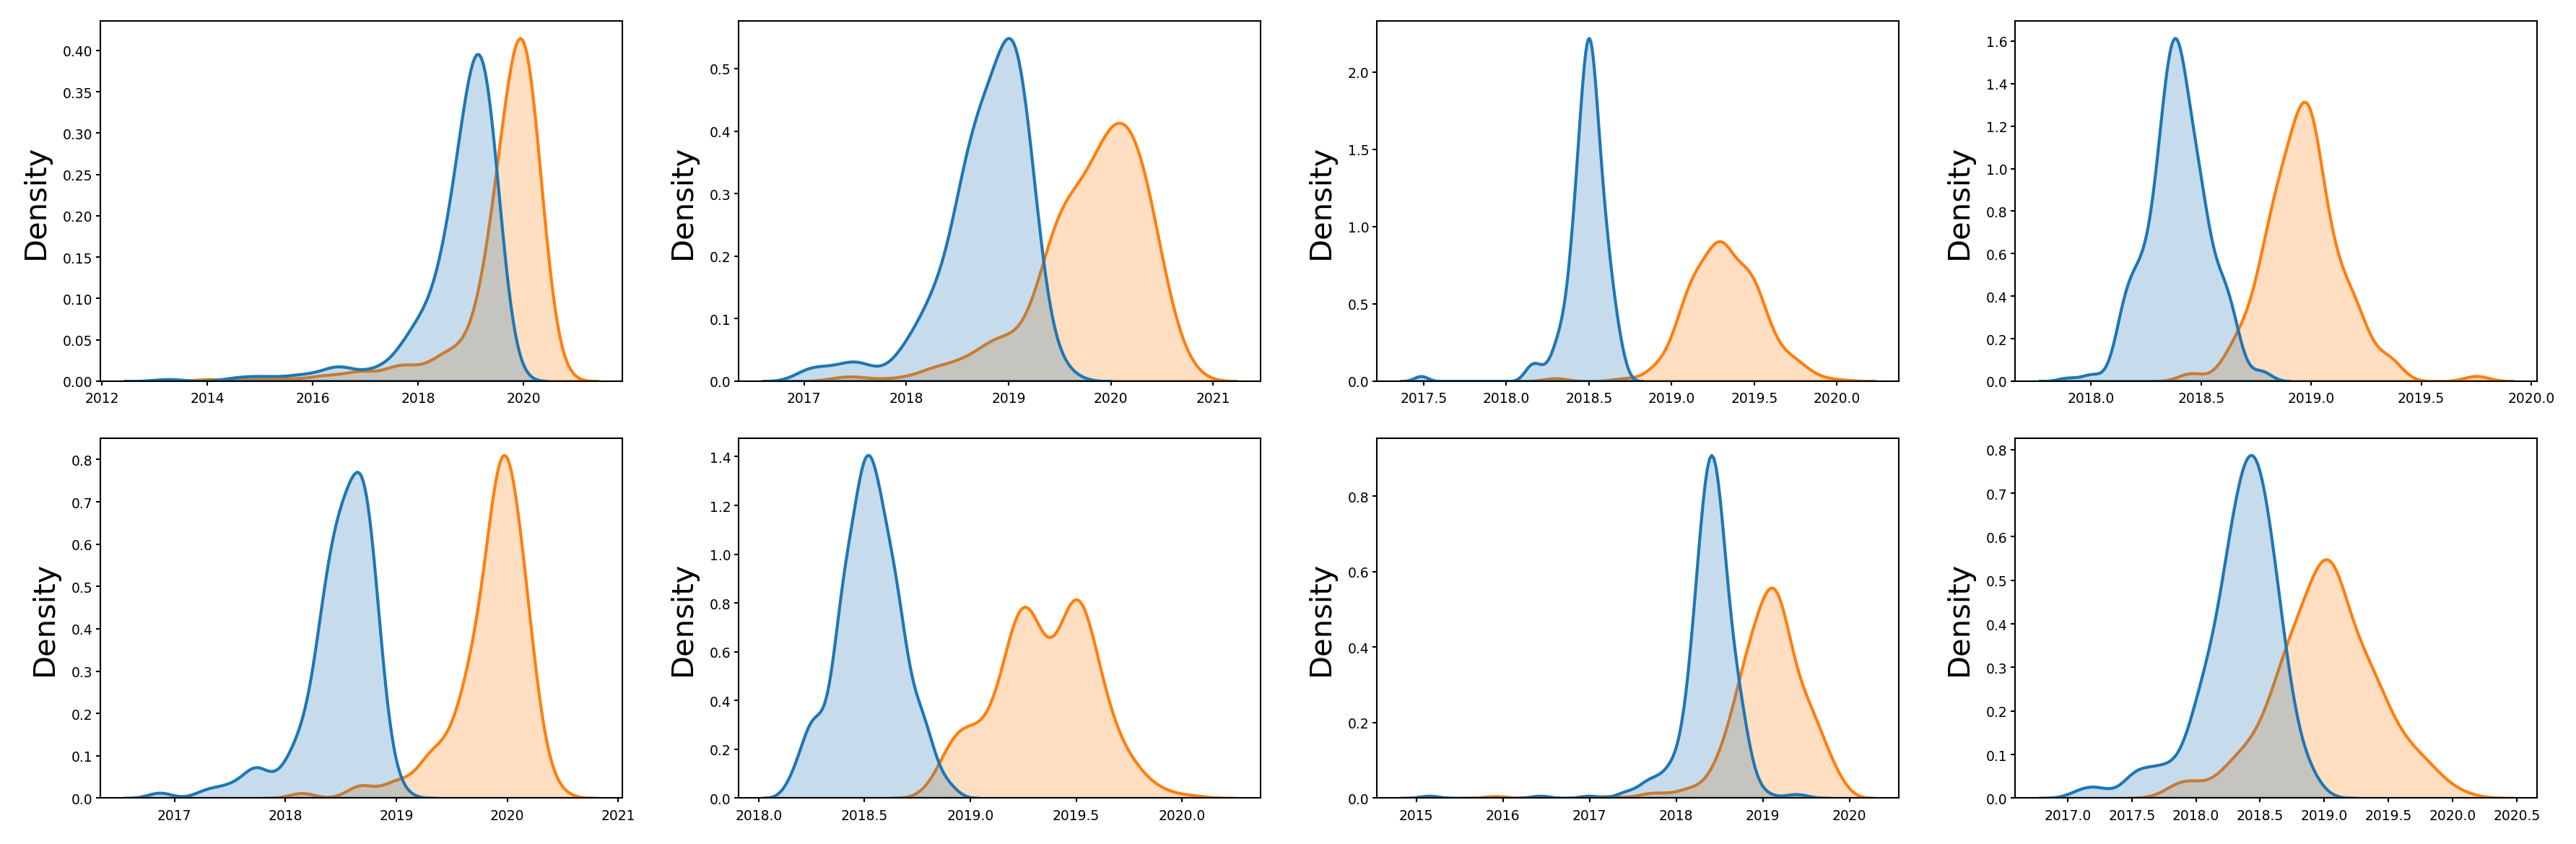

In [23]:
f = plt.figure(figsize=(12, 4))
for i, seg in enumerate(seg_l):
    ax = f.add_subplot(2,4,i+1)
    tmp = pd.DataFrame(loc_dict2[seg]).iloc[:, 4:6].applymap(lambda x: 2021-x)
    sns.kdeplot(data=tmp, ax=ax, legend=False, fill=True)
    
plt.tight_layout()

# show tree with annotations

In [239]:
import baltic as bt

In [240]:
def layout(node):
    node.img_style['vt_line_color'] = host_cmap.get(node.host, '#696969')
    node.img_style['hz_line_color'] = host_cmap.get(node.host, '#696969')
    node.img_style['fgcolor'] = host_cmap.get(node.host, '#696969')
    node.img_style['size'] = 0

    if node.is_leaf():
        isl_name = metainfo.loc[node.name, 'Isolate_Name']
        subtype = metainfo.loc[node.name, 'Subtype']
        date = metainfo.loc[node.name, 'Collection_Date']
        try:
            geno = genotype.loc[node.name, 'group']
        except KeyError:
            geno = ''
        node.add_face(TextFace(f'{node.name}\t{isl_name}\t{subtype}\t{date}\t{geno}', fgcolor=host_cmap.get(node.host, '#696969')), 0, 'branch-right')
        # node.add_face(TextFace(f'{isl_name}\t{subtype}\t{date}'), 0, 'branch-right')

    if (len(node) > 1):
        tmp = d.loc[node.node, 'host2.set.prob']
        tmp_n = d.loc[node.node, 'host2.set']
        try:
            node.add_face(PieChartFace([float(x)*100 for x in tmp], width=16, height=16, colors=[host_cmap.get(n, '#696969') for n in tmp_n]), 0, 'branch-right')
        except TypeError:
            print(node.node, node.host, tmp, tmp_n)


def get_example_tree(s3, d, acc_sets, up=False, scale=150):
    tree = Tree(s3)
    tree.ladderize(1)

    node, depth= tree.get_farthest_leaf()
    most_recent_sample_date = metainfo.loc[node.name, 'Collection_Date']
#     most_recent_sample_date_num = date2num(most_recent_sample_date)
    most_recent_sample_date_num = bt.decimalDate(most_recent_sample_date)

    for node in tree.traverse():
        node_num = int(node.node)
        node.node = node_num
        host_info = d.loc[node_num, 'host2']
        if host_info.find('+'):
            host_info = host_info.split('+')[0]
        node.add_feature('host', host_info)

    acc_in_tree = tree.get_leaf_names()

    for acc_set in acc_sets:
        acc_l = [acc for acc in acc_in_tree if acc in acc_set]

        if len(acc_l) == 0:
            raise ValueError('Make sure with quite group')
        elif len(acc_l) == 1:
            mrca = (tree&acc_l[0]).up
        else:
            mrca = tree.get_common_ancestor(acc_l)
        gmrca = mrca.up
        
        f = lambda x: bt.calendarDate(most_recent_sample_date_num - float(x))

#         f = lambda x: num2date(most_recent_sample_date_num - float(x))
        # print(mrca.node)
        mrca_height = d.loc[mrca.node, 'height']
        gmrca_height = d.loc[gmrca.node, 'height']
        try:
            mrca_height_u, mrca_height_l = d.loc[mrca.node, 'height_0.95_HPD']
            gmrca_height_u, gmrca_height_l = d.loc[gmrca.node, 'height_0.95_HPD']
        except:
            mrca_height_u = mrca_height_l = mrca_height
            gmrca_height_u = gmrca_height_l =gmrca_height
        mrca.add_face(TextFace(f'{f(mrca_height)}\n[{f(mrca_height_l)}, {f(mrca_height_u)}]'), 1, 'float')
        if up:
            gmrca.add_face(TextFace(f'{f(gmrca_height)}\n[{f(gmrca_height_l)}, {f(gmrca_height_u)}]'), 1, 'float')

    ts = TreeStyle()
    ts.show_leaf_name = False
    ts.show_branch_length = False
    ts.show_branch_support = False
    ts.scale = scale
    ts.show_scale = False
    ts.margin_top = 20
    ts.margin_bottom = 20
    ts.margin_right = 100
    ts.margin_left = 80
    ts.legend_position = 1
    for k, v in host_cmap.items():
        ts.legend.add_face(CircleFace(5, v), column=0)
        ts.legend.add_face(TextFace('  ' + k, fsize=5), column=1)

    return ts, tree


def parse_jtree(group, seg):
    dir_group = group.replace('_', '')
    path = f'/home/zeng/DulabWork/H5N8_evolution/data_201910_202108/data/03_beast_analysis/group{dir_group}/ext_{beast_map[group][seg]}_{seg}.mcc.jtree'
    test = json.load(open(path))

    d = pd.DataFrame(test['data'])
    d = d.set_index('edge_num')
    s = test['tree']
    s2 = re.sub("({\d+})(e-\d+)", unifyAnno, s)
    s3 = re.sub("\{(.*?)\}", parseAnno, s2)

#     if isinstance(group, str):
#         acc_l = genotype.query('group == @group').index.to_list()
#     elif isinstance(group, list):
#         acc_l = group
#     else:
#         acc_l = None
    return d, s3

In [201]:
# 2 4_2_3_0_3_2_0_0 MP without height range

# 4 3_2_2_1_2_1_1_2 HA without height range
# 5 1_1_1_1_2_1_1_1 MP without group acc, ['EPI_ISL_985179']

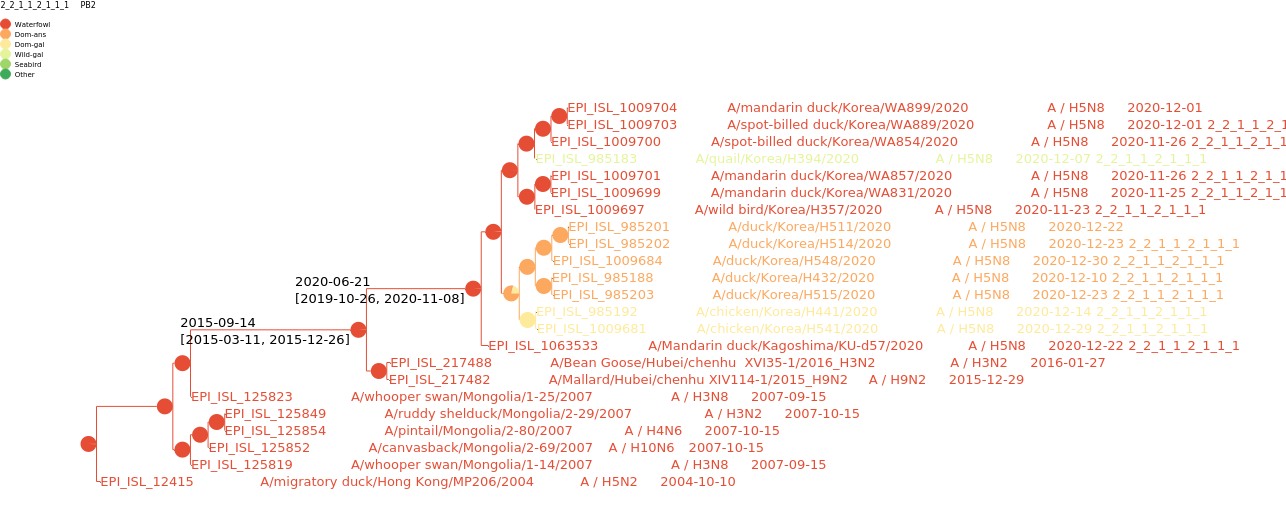

In [241]:
group = domain_group[3]
seg = 'PB2'
d, s3 = parse_jtree(group, seg)

acc_of_group1 = genotype.query('group == "2_2_1_1_2_1_1_1"').index.to_list()
acc_of_group2 = genotype.query('group == "3_2_2_1_2_1_1_2"').index.to_list()

# acc_sets = [acc_of_group1, acc_of_group2, acc_of_group1 + acc_of_group2, acc_of_group1 + ['EPI_ISL_370663']]
# ts, tree = get_example_tree(s3, d, acc_sets)

ts, tree = get_example_tree(s3, d, [acc_of_group1], scale=20, up=True)

ts.title.add_face(TextFace(f'{group}\t{seg} \n', fsize=6), 0)
tree.render("%%inline", tree_style=ts, layout=layout, units='px')
# tree.show()

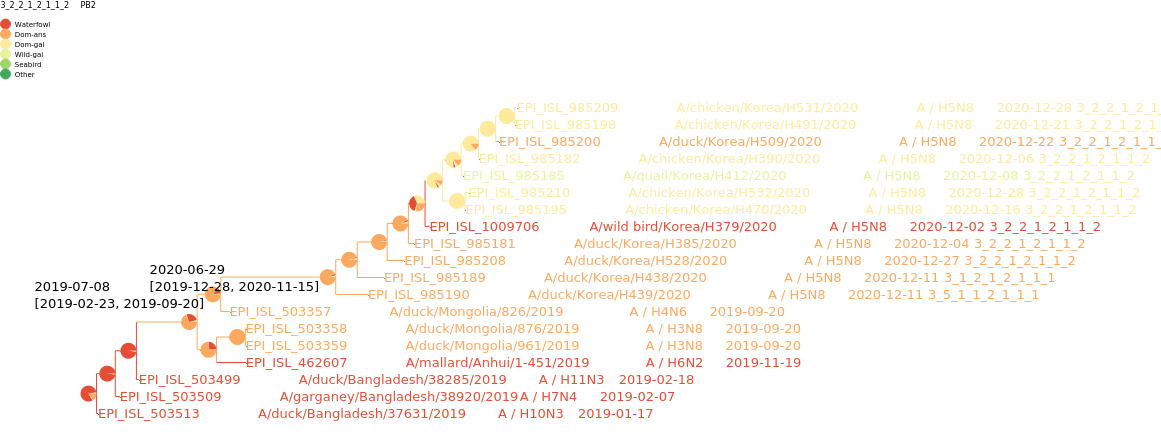

In [232]:
group = domain_group[4]
seg = 'PB2'
d, s3 = parse_jtree(group, seg)

acc_of_group1 = genotype.query('group == "2_2_1_1_2_1_1_1"').index.to_list()
acc_of_group2 = genotype.query('group == "3_2_2_1_2_1_1_2"').index.to_list()

# acc_sets = [acc_of_group1, acc_of_group2, acc_of_group1 + acc_of_group2, acc_of_group1 + ['EPI_ISL_370663']]
# ts, tree = get_example_tree(s3, d, acc_sets)

ts, tree = get_example_tree(s3, d, [acc_of_group2 + ['EPI_ISL_985189', 'EPI_ISL_985190']], scale=100, up=True)

ts.title.add_face(TextFace(f'{group}\t{seg} \n', fsize=6), 0)
tree.render("%%inline", tree_style=ts, layout=layout, units='px')
# tree.show()

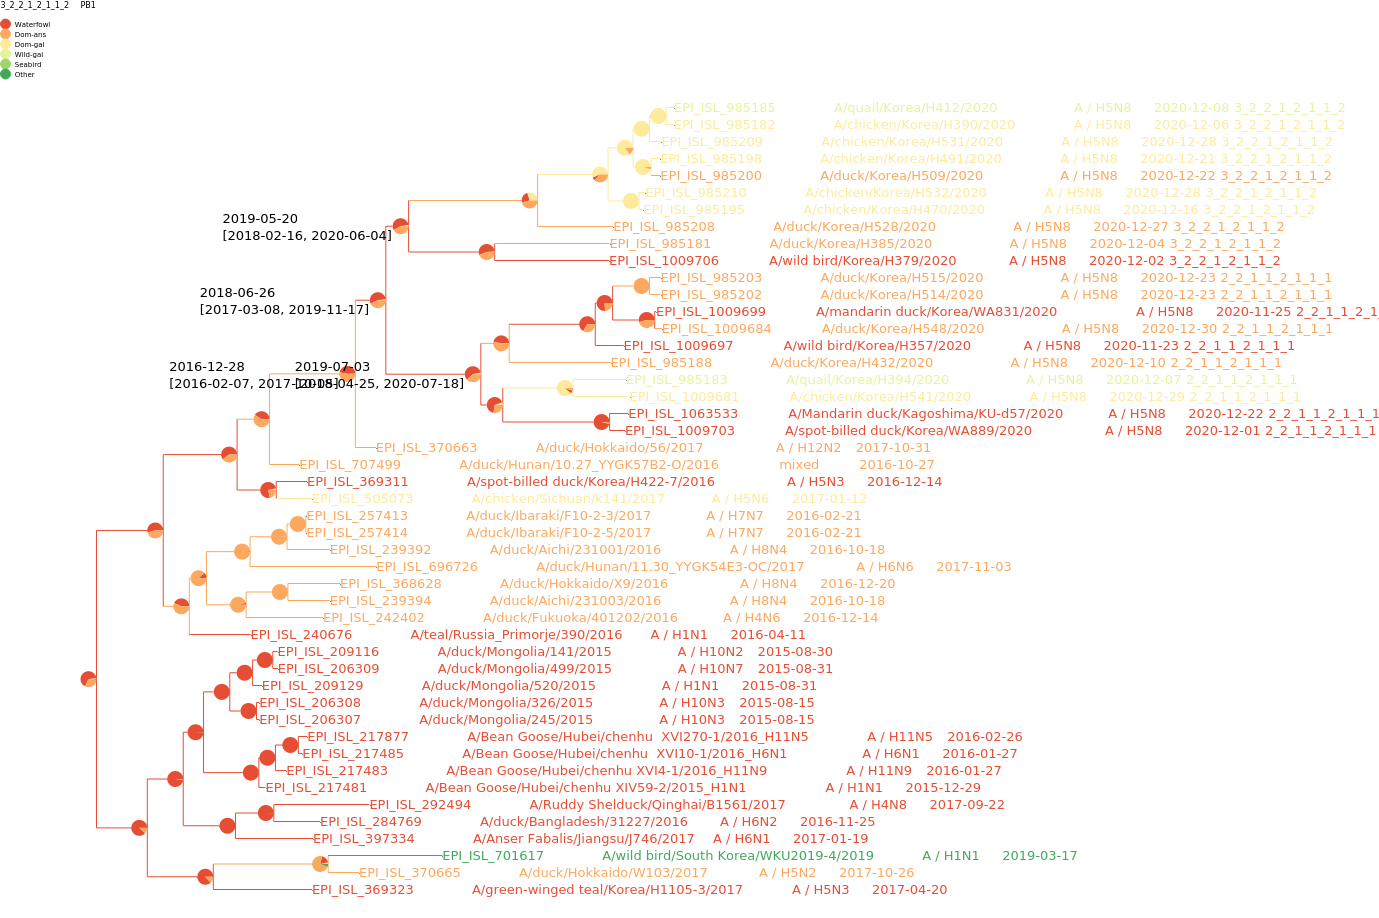

In [242]:
group = domain_group[4]
seg = 'PB1'
d, s3 = parse_jtree(group, seg)

acc_of_group1 = genotype.query('group == "2_2_1_1_2_1_1_1"').index.to_list()
acc_of_group2 = genotype.query('group == "3_2_2_1_2_1_1_2"').index.to_list()

acc_sets = [acc_of_group1, acc_of_group2, acc_of_group1 + acc_of_group2, acc_of_group1 + ['EPI_ISL_370663']]

ts, tree = get_example_tree(s3, d, acc_sets, scale=60)

ts.title.add_face(TextFace(f'{group}\t{seg} \n', fsize=6), 0)
tree.render("%%inline", tree_style=ts, layout=layout, units='px')
# tree.show()

In [245]:
group1 = domain_group[3]
group2 = domain_group[4]
group3 = domain_group[5]
seg = 'NP'

d, s3 = parse_jtree(group1, seg)

acc_of_group1 = genotype.query('group == @group1').index.to_list()
acc_of_group2 = genotype.query('group == @group2').index.to_list()
acc_of_group3 = genotype.query('group == @group3').index.to_list()

acc_sets = [acc_of_group1, acc_of_group2, acc_of_group2 + ['EPI_ISL_985190'], acc_of_group1+acc_of_group2, acc_of_group1 + ['EPI_ISL_985189'], acc_of_group3]

ts, tree = get_example_tree(s3, d, acc_sets, scale=60)
ts.title.add_face(TextFace(f'{group}\t{seg} \n', fsize=6), 0)
tree.render("%%inline", tree_style=ts, layout=layout, units='px')
# tree.show(tree_style=ts, layout=layout)

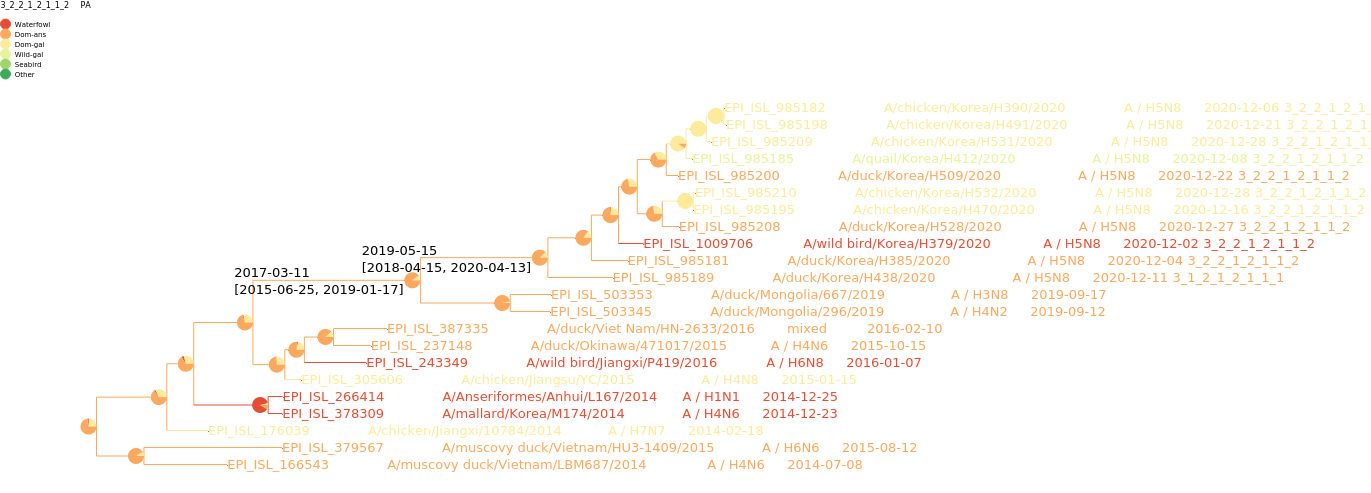

In [221]:
group = domain_group[4]
seg = 'PA'
d, s3 = parse_jtree(group, seg)

acc_of_group = genotype.query('group == @group').index.to_list()
# acc_of_group.extend(['EPI_ISL_985190', 'EPI_ISL_985189', 'EPI_ISL_1009706'])
# acc_of_group.extend(['EPI_ISL_985189', 'EPI_ISL_1009706'])
# acc_of_group.extend(['EPI_ISL_985189'])

ts, tree = get_example_tree(s3, d, [acc_of_group + ['EPI_ISL_985189']], scale=50, up=True)
ts.title.add_face(TextFace(f'{group}\t{seg} \n', fsize=6), 0)
tree.render("%%inline", tree_style=ts, layout=layout, units='px')
# tree.show()

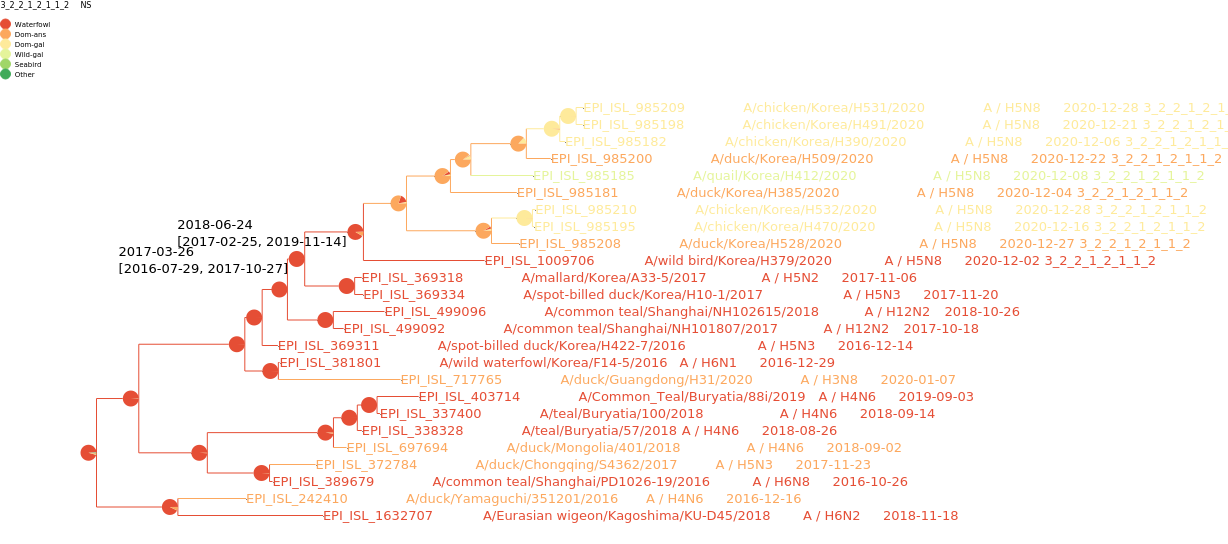

In [222]:
group = domain_group[4]
seg = 'NS'
d, s3 = parse_jtree(group, seg)

acc_of_group = genotype.query('group == @group').index.to_list()
# acc_of_group.extend(['EPI_ISL_985190', 'EPI_ISL_985189', 'EPI_ISL_1009706'])
# acc_of_group.extend(['EPI_ISL_985189', 'EPI_ISL_1009706'])
# acc_of_group.extend(['EPI_ISL_985189'])

ts, tree = get_example_tree(s3, d, [acc_of_group + ['EPI_ISL_985189']], scale=40, up=True)
ts.title.add_face(TextFace(f'{group}\t{seg} \n', fsize=6), 0)
tree.render("%%inline", tree_style=ts, layout=layout, units='px')
# tree.show()

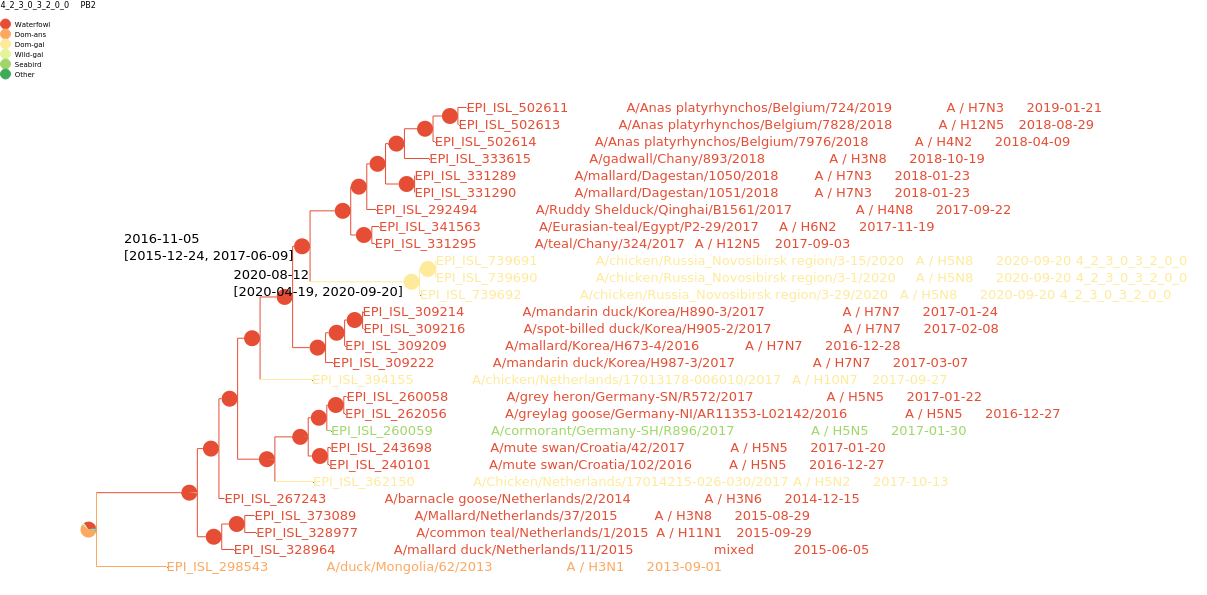

In [223]:
group = domain_group[2]
seg = 'PB2'
d, s3 = parse_jtree(group, seg)

acc_of_group = genotype.query('group == @group').index.to_list()

ts, tree = get_example_tree(s3, d, [acc_of_group], up=True, scale=20)
ts.title.add_face(TextFace(f'{group}\t{seg} \n', fsize=6), 0)
tree.render("%%inline", tree_style=ts, layout=layout, units='px')
# tree.show()

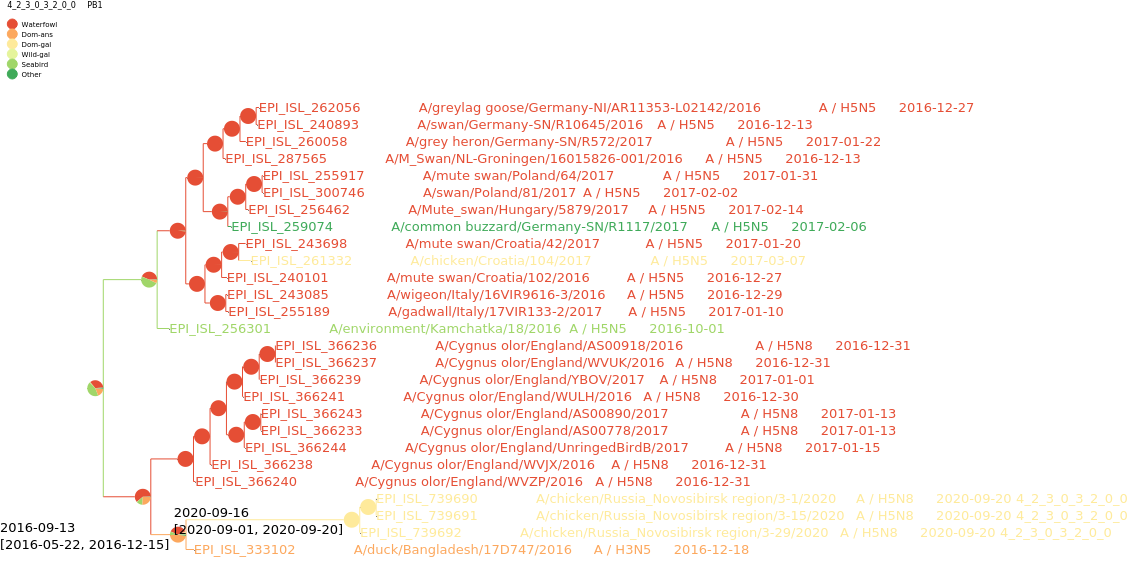

In [225]:
group = domain_group[2]
seg = 'PB1'
d, s3 = parse_jtree(group, seg)

acc_of_group = genotype.query('group == @group').index.to_list()

ts, tree = get_example_tree(s3, d, [acc_of_group], up=True, scale=40)
ts.title.add_face(TextFace(f'{group}\t{seg} \n', fsize=6), 0)
tree.render("%%inline", tree_style=ts, layout=layout, units='px')
# tree.show()

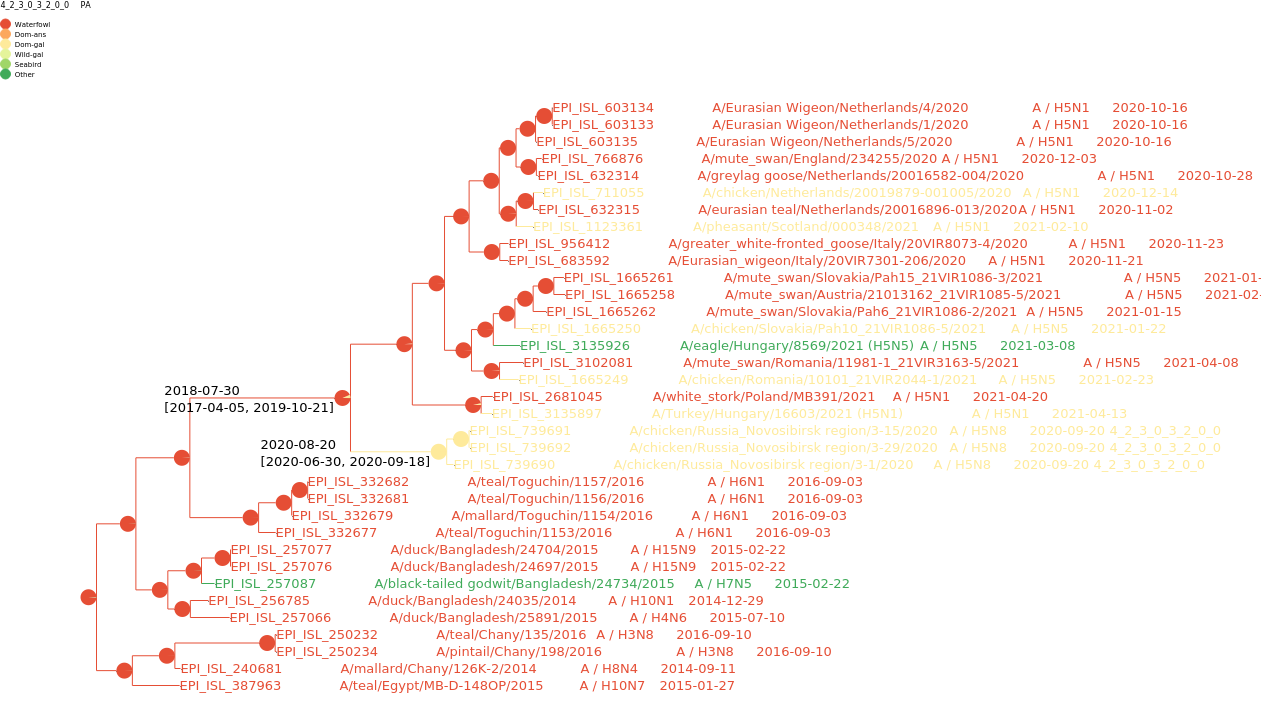

In [228]:
group = domain_group[2]
seg = 'PA'
d, s3 = parse_jtree(group, seg)

acc_of_group = genotype.query('group == @group').index.to_list()

ts, tree = get_example_tree(s3, d, [acc_of_group], up=True, scale=40)
ts.title.add_face(TextFace(f'{group}\t{seg} \n', fsize=6), 0)
tree.render("%%inline", tree_style=ts, layout=layout, units='px')
# tree.show()

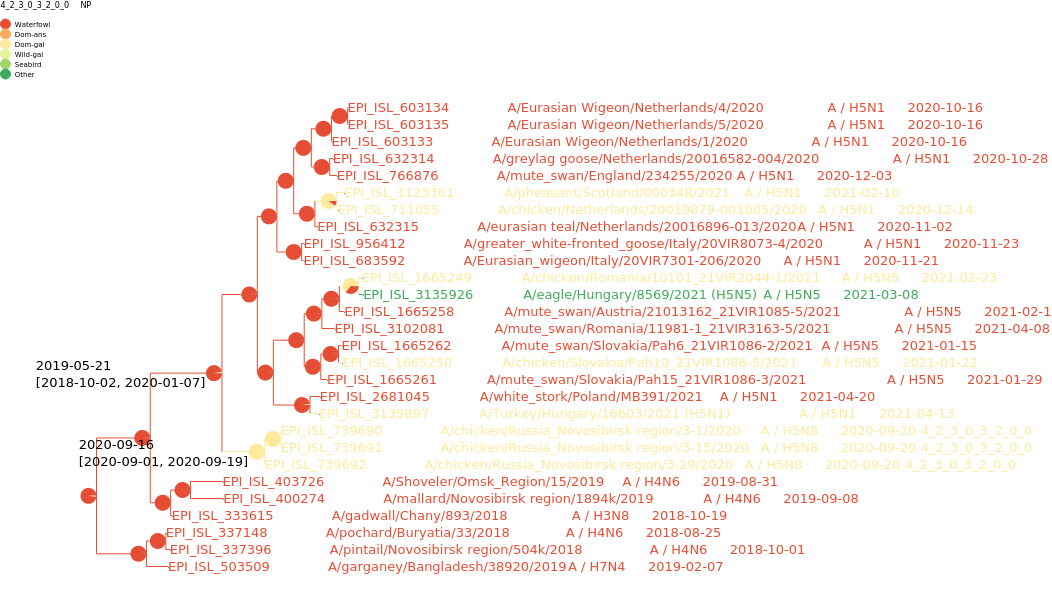

In [229]:
group = domain_group[2]
seg = 'NP'
d, s3 = parse_jtree(group, seg)

acc_of_group = genotype.query('group == @group').index.to_list()

ts, tree = get_example_tree(s3, d, [acc_of_group], up=True, scale=40)
ts.title.add_face(TextFace(f'{group}\t{seg} \n', fsize=6), 0)
tree.render("%%inline", tree_style=ts, layout=layout, units='px')
# tree.show()

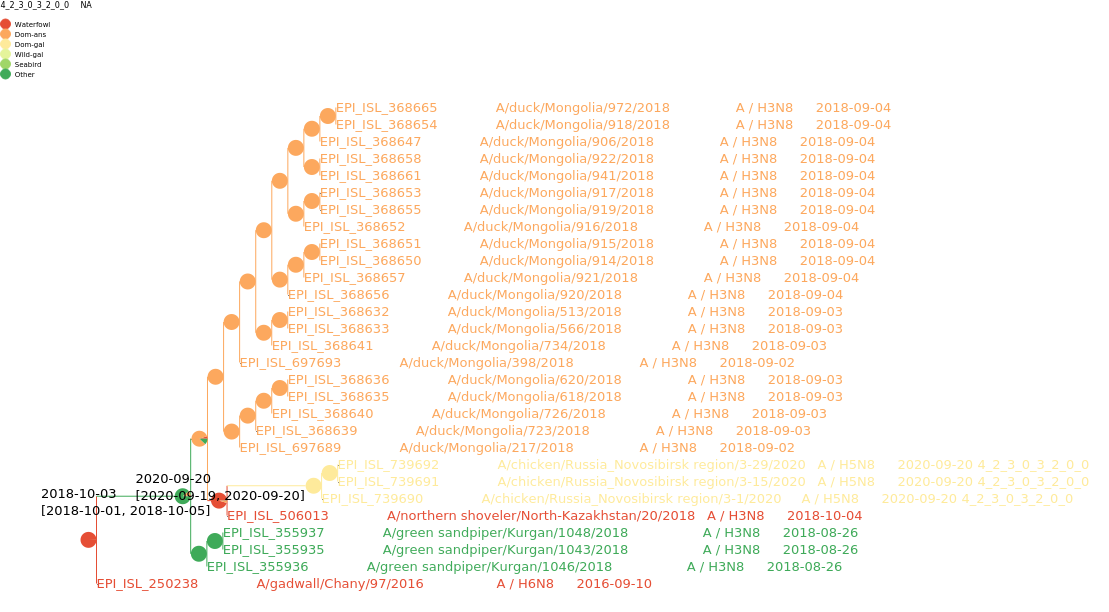

In [230]:
group = domain_group[2]
seg = 'NA'
d, s3 = parse_jtree(group, seg)

acc_of_group = genotype.query('group == @group').index.to_list()

ts, tree = get_example_tree(s3, d, [acc_of_group], up=True, scale=40)
ts.title.add_face(TextFace(f'{group}\t{seg} \n', fsize=6), 0)
tree.render("%%inline", tree_style=ts, layout=layout, units='px')
# tree.show()

# Host and time of MRCA and GMRCA

In [178]:
def parse_attr(node, most_recent_sample_date_num, d):
    f = lambda x: datetime.strptime(num2date(most_recent_sample_date_num - x), '%Y-%m-%d')
    height_m = float(d.loc[node.node, 'height'])
    try:
        height_l, height_u = d.loc[node.node, 'height_0.95_HPD']
    except:
        height_l = height_u = height_m
    l1, l2 = d.loc[node.node, ['host2.set', 'host2.set.prob']]
    host_dict = dict(zip(l1, l2))
    host_set_prob = [host_dict.get(host, 0) for host in host_l]
    
    return [f(height_m), f(height_l), f(height_u)] + host_set_prob


def extractMccTree(path, acc_of_group):
    test = json.load(open(path))
    d = pd.DataFrame(test['data'])
    d = d.set_index('edge_num')
    s = test['tree']

    s2 = re.sub("({\d+})(e-\d+)", unifyAnno, s)
    s3 = re.sub("\{(.*?)\}", parseAnno, s2)

    tree = Tree(s3)
    tree.ladderize(1)

    node, depth= tree.get_farthest_leaf()
    most_recent_sample_date = metainfo.loc[node.name, 'Collection_Date']
    most_recent_sample_date_num = date2num(most_recent_sample_date)

    for node in tree.traverse():
        node_num = int(node.node)
        node.node = node_num
        host_info = d.loc[node_num, 'host2']
        node.add_feature('host', host_info)

    # acc_of_group = genotype.query('group == @group').index.to_list()
    acc_in_tree = tree.get_leaf_names()
    acc_l = [acc for acc in acc_in_tree if acc in acc_of_group]

        
    if len(acc_l) == 0:
        raise ValueError('Make sure with quite group')
    elif len(acc_l) == 1:
        mrca = (tree&acc_l[0]).up
    else:
        mrca = tree.get_common_ancestor(acc_l)
    mrcga = mrca.up

    return parse_attr(mrca, most_recent_sample_date_num, d),  parse_attr(mrcga, most_recent_sample_date_num, d)

In [179]:
def draw_ancestor_time(ax, group, anster_est):
    ax.vlines(x=np.arange(8)+0.25, ymin=anster_est['height_l']['mrca'], ymax=anster_est['height_u']['mrca'], lw=2, colors=color_seg, alpha=0.8)
    ax.scatter(x=np.arange(8)+0.25, y=anster_est['height_m']['mrca'], c=color_seg, alpha=0.8, s=4)
    ax.vlines(x=np.arange(8)-0.25, ymin=anster_est['height_l']['mrcga'], ymax=anster_est['height_u']['mrcga'], lw=2, colors=color_seg, alpha=0.6, linestyles='dashed')
    ax.scatter(x=np.arange(8)-0.25, y=anster_est['height_m']['mrcga'], c=color_seg, alpha=0.5, s=4)

    # ax.set_title(f'Origin time of MRCA and MRGCA for \ngroup {group}', style='italic', weight='bold', fontsize=6)
    ax.set_xlabel('Segment', fontsize=6)
    ax.set_ylabel('Time', fontsize=6)
    ax.grid(which='major', axis='y', linestyle='--', linewidth='0.5', color='grey', alpha=0.4)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.xticks(np.arange(8), labels=seg_l)

In [180]:
def sub_i(ax, seg, s, anster_est):
    tmp = anster_est.loc[seg, (host_l, )].unstack(0).T.applymap(lambda x: float(x))[['mrcga', 'mrca']]
    data = tmp
    data_cum = data.cumsum(axis=0)
    width = 0.5

    x = []
    for i in range(s, s+2):
        x = x + [i-width/2, i, i+width/2]

    d = data.values.tolist()
    d2 = []
    for i in range(6):
        y = []
        for j in range(2):
            y = y + np.repeat(d[i][j], 3).tolist()
        d2.append(y)

    ax.stackplot(x, d2, labels=host_l, colors=color_host, linewidth=0.1, edgecolor='w', alpha=0.6)

    for i, colname in enumerate(host_l):
        heights = data.iloc[i, :]
        starts = data_cum.iloc[i, :] - heights
        ax.bar([s, s+1], heights, bottom=starts, width=0.5, label=colname, color=color_host[i])


def draw_ancestor_host(ax, group, anster_est):
    sub_i(ax, 'PB2', 0, anster_est)
    sub_i(ax, 'PB1', 2, anster_est)
    sub_i(ax, 'PA', 4, anster_est)
    sub_i(ax, 'HA', 6, anster_est)
    sub_i(ax, 'NP', 8, anster_est)
    sub_i(ax, 'NA', 10, anster_est)
    sub_i(ax, 'MP', 12, anster_est)
    sub_i(ax, 'NS', 14, anster_est)

    import matplotlib.patches as mpatches
    patches = []
    for color, seg in zip(color_host, host_l):
        patches.append(mpatches.Patch(color=color, label=seg))
    # plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), handles=patches, frameon=False, fontsize=4)
    plt.legend(loc='lower left', bbox_to_anchor=(0, 1.01), handles=patches, frameon=False, fontsize=4, ncol=6)

    ax.grid(which='major', axis='y', linestyle='--', linewidth='0.5', color='grey', alpha=0.4)
    for spine in plt.gca().spines.keys():
        if spine == "top" or spine == "right" or spine == "left":
            plt.gca().spines[spine].set_color("none")

    # ax.text(-0.5, 1.07, s='Ancestor estimation', weight='bold', size=15)
    # ax.text(-0.5, 1.02, s=f'for Group {group}', size=10)
    # ax.set_title(f'Origin host of MRCA and MRGCA for \ngroup {group}', style='italic', weight='bold', fontsize=6)
    ax.set_xlabel('Segment', fontsize=6)
    ax.set_ylabel('Probability', fontsize=6)
    plt.xticks(np.arange(0.5, 16.5, 2), seg_l)

In [181]:
group = '1_1_1_1_1_1_1_1'

df_l = []
for seg in seg_l:
    dir_group = group.replace('_', '')
    path = f'/home/zeng/DulabWork/H5N8_evolution/data_201910_202108/data/03_beast_analysis/group{dir_group}/ext_{beast_map[group][seg]}_{seg}.mcc.jtree'
    acc_of_group = genotype.query('group == @group').index.to_list()
    t = pd.DataFrame(extractMccTree(path, acc_of_group), columns=['height_m', 'height_l', 'height_u', 'Waterfowl', 'Dom-ans', 'Dom-gal', 'Wild-gal', 'Seabird', 'Other'], index=[[seg, seg], ['mrca', 'mrcga']])
    df_l.append(t)

anster_est = pd.concat(df_l).unstack(1).reindex(seg_l)
anster_est

height_m              height_l              height_u             \
          mrca      mrcga       mrca      mrcga       mrca      mrcga   
PB2 2019-09-09 2018-11-02 2019-11-20 2019-04-25 2019-06-20 2018-04-08   
PB1 2019-08-09 2018-05-23 2019-11-05 2018-09-19 2019-05-05 2018-02-05   
PA  2019-10-11 2018-12-11 2019-11-21 2019-04-02 2019-09-01 2018-07-11   
HA  2019-09-23 2019-02-26 2019-11-18 2019-05-19 2019-08-01 2018-11-29   
NP  2019-10-17 2018-06-04 2019-11-30 2018-08-15 2019-08-21 2018-03-08   
NA  2019-09-09 2018-11-09 2019-11-19 2019-03-16 2019-07-05 2018-06-11   
MP  2019-08-25 2018-12-15 2019-11-22 2019-05-24 2019-05-06 2018-05-24   
NS  2019-09-11 2019-01-08 2019-11-30 2019-06-07 2019-06-05 2018-05-16   

    Waterfowl         Dom-ans         Dom-gal         Wild-gal          \
         mrca   mrcga    mrca   mrcga    mrca   mrcga     mrca   mrcga   
PB2    0.0500  0.0633  0.4233  0.2867  0.5167  0.5367      0.0  0.0033   
PB1    0.0733  0.6512  0.2800  0.1860  0.6367  0.1163      0.0  0.0000   
PA     0.0767  0.1433  0.5267  0.2767  0.3967  0.5033      0.0  0.0033   
HA     0.0167  0.0400  0.3300  0.2233  0.6400  0.6000      0.0  0.0000   
NP     0.0833  0.4511  0.4567  0.5000  0.4600  0.0489      0.0  0.0000   
NA     0.0400  0.0700  0.4367  0.2167  0.4567  0.5500      0.0  0.0000   
MP     0.0267  0.0733  0.3467  0.1800  0.6233  0.7200      0.0  0.0000   
NS     0.1767  0.1267  0.4067  0.2733  0.4133  0.5267      0.0  0.0133   

    Seabird           Other          
       mrca   mrcga    mrca   mrcga  
PB2     0.0  0.0033  0.0100  0.1067  
PB1     0.0  0.0000  0.0100  0.0465  
PA      0.0  0.0000  0.0000  0.0733  
HA      0.0  0.0000  0.0133  0.1367  
NP      0.0  0.0000  0.0000  0.0000  
NA      0.0  0.0033  0.0667  0.1600  
MP      0.0  0.0000  0.0033  0.0267  
NS      0.0  0.0000  0.0033  0.0600

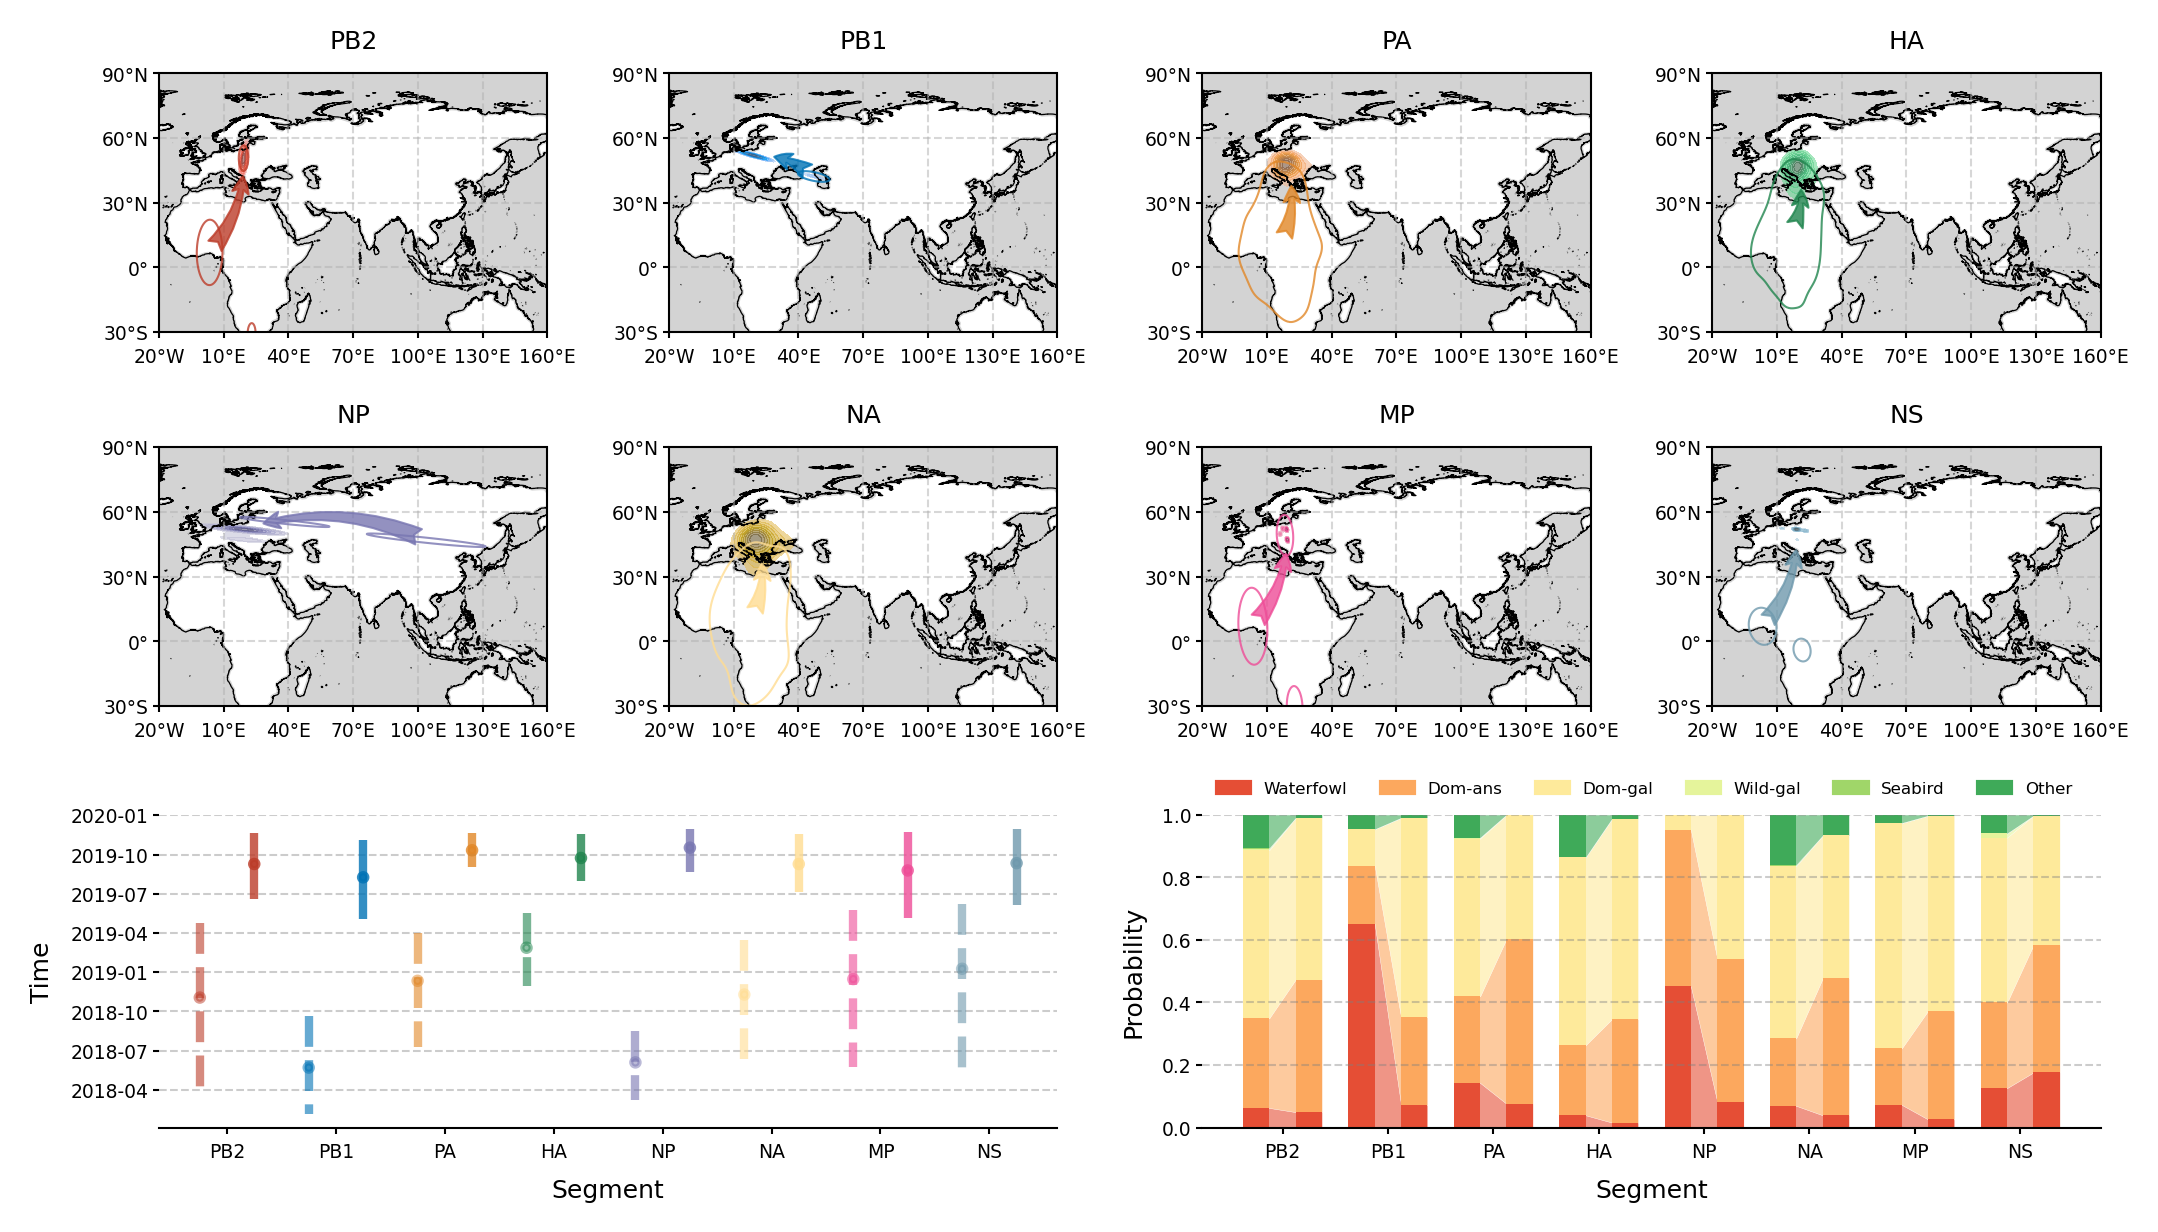

In [182]:
fig3 = plt.figure(constrained_layout=True, figsize=(7.08, 4))
gs = fig3.add_gridspec(3, 4)
proj = ccrs.PlateCarree()

f3_ax1 = fig3.add_subplot(gs[0, 0], projection=proj)
draw_single_seg_map(f3_ax1, 'PB2', loc_dict2['PB2'], color_seg[0])

f3_ax2 = fig3.add_subplot(gs[0, 1], projection=proj)
draw_single_seg_map(f3_ax2, 'PB1', loc_dict2['PB1'], color_seg[1])

f3_ax3 = fig3.add_subplot(gs[0, 2], projection=proj)
draw_single_seg_map(f3_ax3, 'PA', loc_dict2['PA'], color_seg[2])

f3_ax4 = fig3.add_subplot(gs[0, 3], projection=proj)
draw_single_seg_map(f3_ax4, 'HA', loc_dict2['HA'], color_seg[3])

f3_ax5 = fig3.add_subplot(gs[1, 0], projection=proj)
draw_single_seg_map(f3_ax5, 'NP', loc_dict2['NP'], color_seg[4])

f3_ax6 = fig3.add_subplot(gs[1, 1], projection=proj)
draw_single_seg_map(f3_ax6, 'NA', loc_dict2['NA'], color_seg[5])

f3_ax7 = fig3.add_subplot(gs[1, 2], projection=proj)
draw_single_seg_map(f3_ax7, 'MP', loc_dict2['MP'], color_seg[6])

f3_ax8 = fig3.add_subplot(gs[1, 3], projection=proj)
draw_single_seg_map(f3_ax8, 'NS', loc_dict2['NS'], color_seg[7])

f3_ax9 = fig3.add_subplot(gs[2, 0:2])
draw_ancestor_time(f3_ax9, group, anster_est)

f3_ax10 = fig3.add_subplot(gs[2, 2:4])
draw_ancestor_host(f3_ax10, group, anster_est)

# fig3.suptitle(f'Most Recent Common Ancestor Estimation for Group {group}', style='italic', weight='bold', fontsize=8)
plt.show()

In [39]:
group = '0_0_0_0_0_0_0_0'

df_l = []
for seg in seg_l:
    dir_group = group.replace('_', '')
    path = f'/home/zeng/DulabWork/H5N8_evolution/data_201910_202108/data/03_beast_analysis/group{dir_group}/ext_{beast_map[group][seg]}_{seg}.mcc.jtree'
    acc_of_group = genotype.query('group == @group').index.to_list()
    t = pd.DataFrame(extractMccTree(path, acc_of_group), columns=['height_m', 'height_l', 'height_u', 'Waterfowl', 'Dom-ans', 'Dom-gal', 'Wild-gal', 'Seabird', 'Other'], index=[[seg, seg], ['mrca', 'mrcga']])
    df_l.append(t)

anster_est2 = pd.concat(df_l).unstack(1).reindex(seg_l)
anster_est2

height_m              height_l              height_u             \
          mrca      mrcga       mrca      mrcga       mrca      mrcga   
PB2 2019-09-20 2017-06-20 2020-02-13 2017-12-23 2019-02-22 2016-12-09   
PB1 2019-10-27 2017-04-27 2020-02-23 2017-11-28 2019-06-05 2017-01-19   
PA  2019-09-20 2017-05-17 2020-02-19 2017-10-29 2019-04-15 2016-11-25   
HA  2019-10-31 2017-02-27 2020-02-26 2017-05-02 2019-06-28 2016-12-09   
NP  2019-06-16 2018-04-05 2020-01-05 2018-11-15 2018-11-28 2017-05-29   
NA  2019-09-04 2017-01-21 2020-02-16 2017-04-24 2019-02-01 2016-10-02   
MP  2019-09-15 2017-11-13 2020-01-28 2018-07-06 2019-03-29 2017-03-16   
NS  2019-10-11 2018-01-31 2020-02-28 2018-04-26 2019-05-24 2017-11-04   

    Waterfowl         Dom-ans         Dom-gal         Wild-gal          \
         mrca   mrcga    mrca   mrcga    mrca   mrcga     mrca   mrcga   
PB2    0.0757  0.2257  0.2712  0.1082  0.6484  0.6602   0.0007  0.0004   
PB1    0.2423  0.1163  0.2172  0.5607  0.5347  0.3192   0.0006  0.0003   
PA     0.1222  0.1364  0.2109  0.1739  0.6645  0.6885   0.0003  0.0001   
HA     0.2198  0.1443  0.1516  0.0259  0.6179  0.8186   0.0007  0.0000   
NP     0.1337  0.1120  0.3085  0.2581  0.5520  0.6277   0.0010  0.0000   
NA     0.0899  0.2779  0.3382  0.0428  0.5624  0.6763   0.0003  0.0002   
MP     0.3495  0.3206  0.0702  0.4277  0.5779  0.2495   0.0000  0.0000   
NS     0.2313  0.0210  0.0190  0.0010  0.7480  0.9780   0.0001  0.0000   

    Seabird           Other          
       mrca   mrcga    mrca   mrcga  
PB2  0.0007  0.0006  0.0034  0.0051  
PB1  0.0003  0.0000  0.0049  0.0036  
PA   0.0006  0.0003  0.0016  0.0008  
HA   0.0003  0.0000  0.0097  0.0112  
NP   0.0008  0.0005  0.0040  0.0016  
NA   0.0007  0.0001  0.0086  0.0027  
MP   0.0003  0.0007  0.0020  0.0014  
NS   0.0007  0.0000  0.0009  0.0000

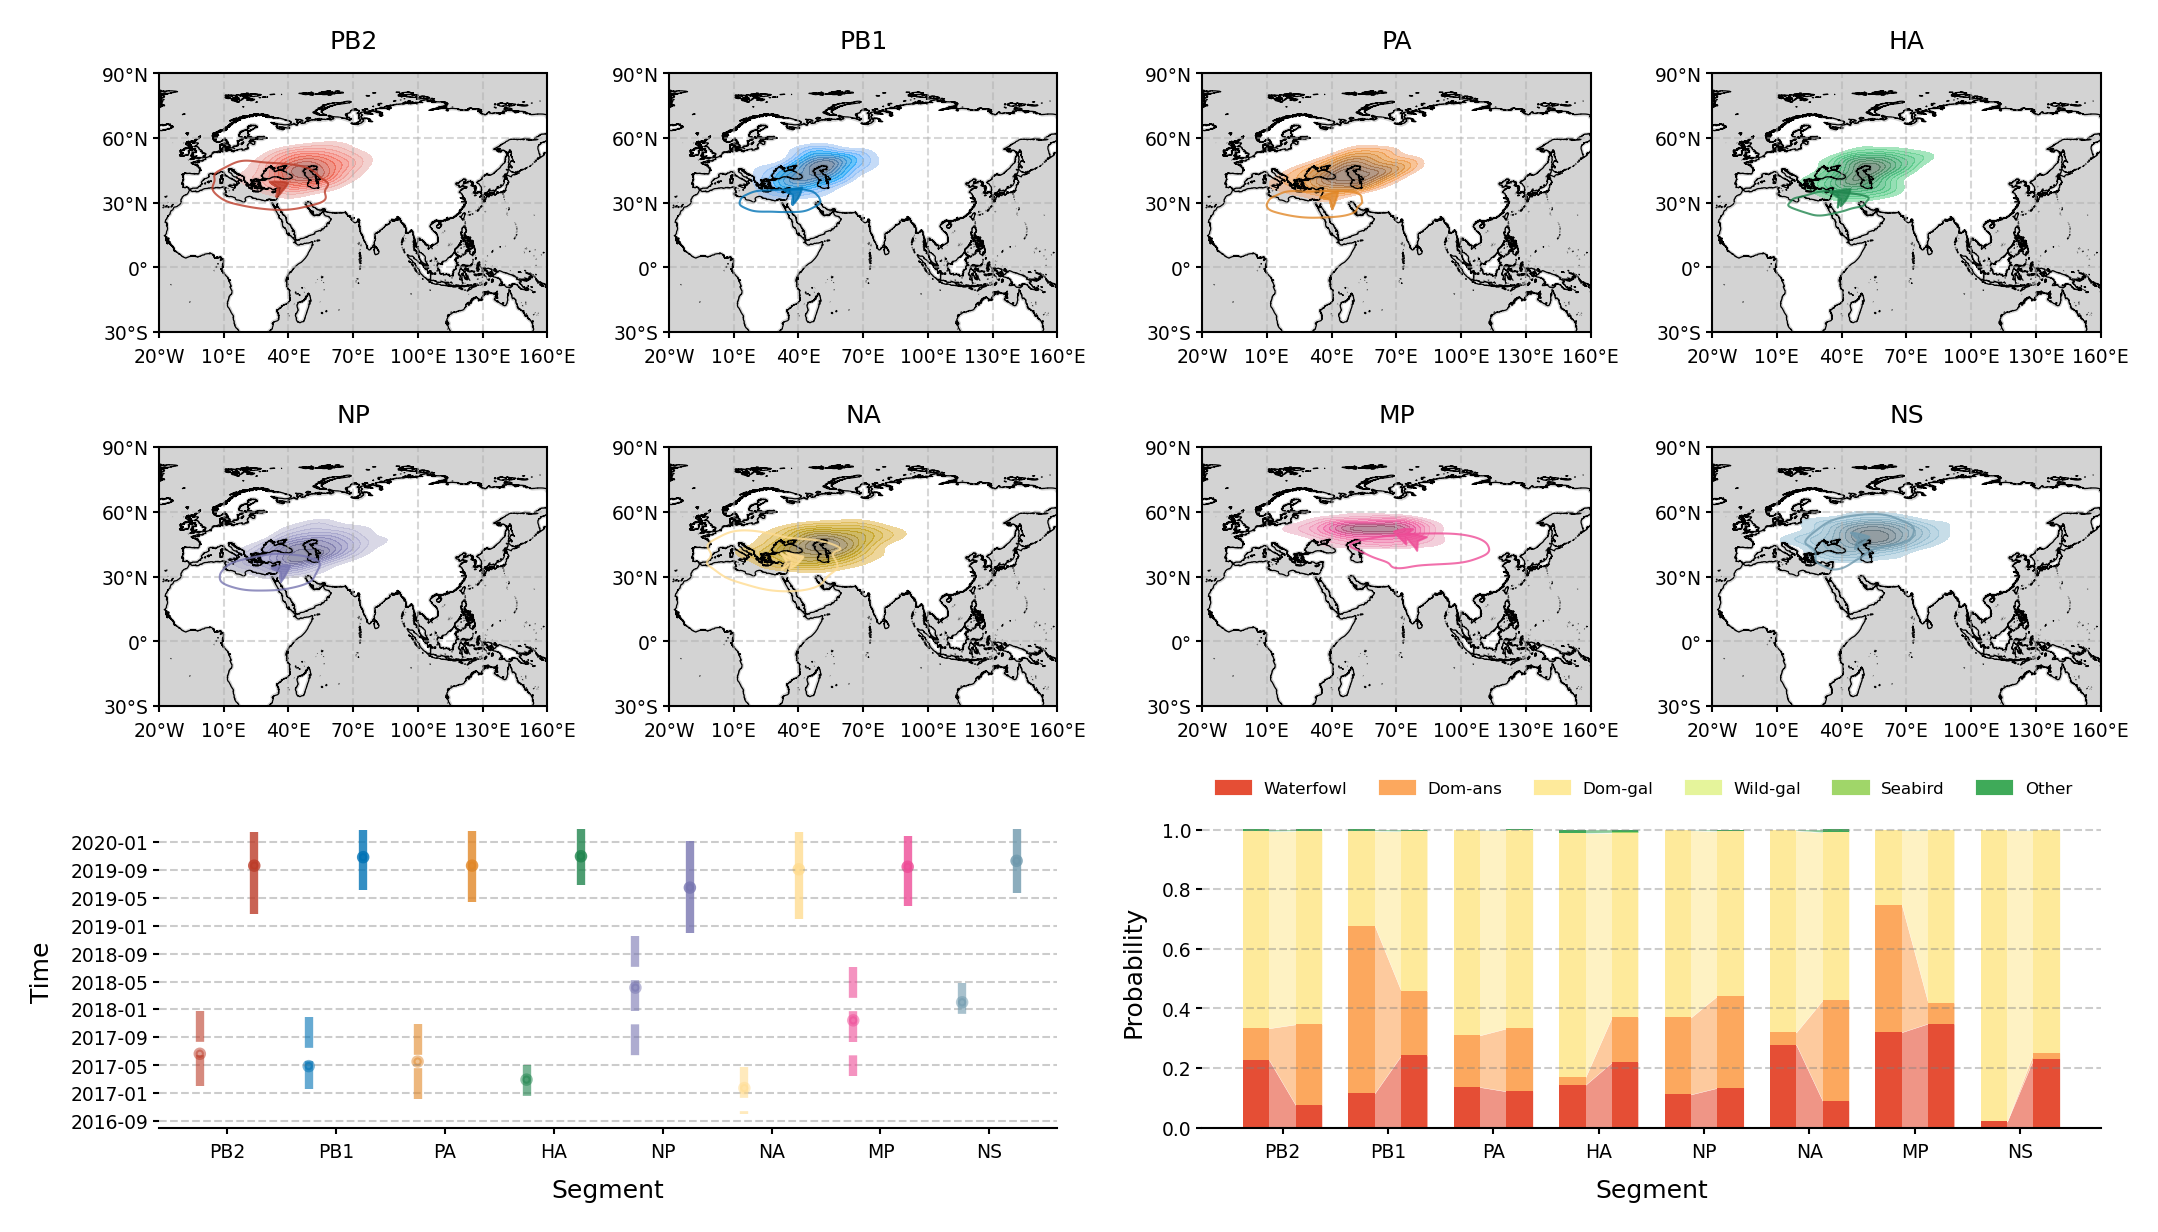

In [40]:
fig3 = plt.figure(constrained_layout=True, figsize=(7.08, 4))
gs = fig3.add_gridspec(3, 4)
proj = ccrs.PlateCarree()

f3_ax1 = fig3.add_subplot(gs[0, 0], projection=proj)
draw_single_seg_map(f3_ax1, 'PB2', loc_dict1['PB2'], color_seg[0])

f3_ax2 = fig3.add_subplot(gs[0, 1], projection=proj)
draw_single_seg_map(f3_ax2, 'PB1', loc_dict1['PB1'], color_seg[1])

f3_ax3 = fig3.add_subplot(gs[0, 2], projection=proj)
draw_single_seg_map(f3_ax3, 'PA', loc_dict1['PA'], color_seg[2])

f3_ax4 = fig3.add_subplot(gs[0, 3], projection=proj)
draw_single_seg_map(f3_ax4, 'HA', loc_dict1['HA'], color_seg[3])

f3_ax5 = fig3.add_subplot(gs[1, 0], projection=proj)
draw_single_seg_map(f3_ax5, 'NP', loc_dict1['NP'], color_seg[4])

f3_ax6 = fig3.add_subplot(gs[1, 1], projection=proj)
draw_single_seg_map(f3_ax6, 'NA', loc_dict1['NA'], color_seg[5])

f3_ax7 = fig3.add_subplot(gs[1, 2], projection=proj)
draw_single_seg_map(f3_ax7, 'MP', loc_dict1['MP'], color_seg[6])

f3_ax8 = fig3.add_subplot(gs[1, 3], projection=proj)
draw_single_seg_map(f3_ax8, 'NS', loc_dict1['NS'], color_seg[7])

f3_ax9 = fig3.add_subplot(gs[2, 0:2])
draw_ancestor_time(f3_ax9, group, anster_est2)

f3_ax10 = fig3.add_subplot(gs[2, 2:4])
draw_ancestor_host(f3_ax10, group, anster_est2)

# fig3.suptitle(f'Most Recent Common Ancestor Estimation for Group {group}', style='italic', weight='bold')
plt.show()

In [66]:
group = domain_group[3]
print(group)
df_l = []
for seg in seg_l:
    dir_group = group.replace('_', '')
    path = f'/home/zeng/DulabWork/H5N8_evolution/data_201910_202108/data/03_beast_analysis/group{dir_group}/ext_{beast_map[group][seg]}_{seg}.mcc.jtree'
    acc_in_group = genotype.query('group == @group').index.to_list()
    t = pd.DataFrame(extractMccTree(path, acc_in_group), columns=['height_m', 'height_l', 'height_u', 'Waterfowl', 'Dom-ans', 'Dom-gal', 'Wild-gal', 'Seabird', 'Other'], index=[[seg, seg], ['mrca', 'mrcga']])
    df_l.append(t)

anster_est3 = pd.concat(df_l).unstack(1).reindex(seg_l)
anster_est3

2_2_1_1_2_1_1_1


height_m              height_l              height_u             \
          mrca      mrcga       mrca      mrcga       mrca      mrcga   
PB2 2020-06-22 2015-09-15 2020-11-08 2015-12-28 2019-10-27 2015-03-13   
PB1 2019-07-04 2018-06-27 2020-07-19 2019-11-19 2018-04-27 2017-03-10   
PA  2020-10-31 2020-09-09 2020-11-16 2020-10-06 2020-10-14 2020-08-27   
HA  2020-09-08 2020-08-29 2020-10-05 2020-09-29 2020-07-28 2020-07-28   
NP  2020-09-29 2020-08-06 2020-11-14 2020-10-22 2020-08-03 2020-05-08   
NA  2020-09-03 2020-07-25 2020-09-05 2020-09-18 2020-08-28 2020-05-29   
MP  2020-11-01 2020-10-16 2020-11-20 2020-11-11 2020-10-07 2020-09-15   
NS  2020-10-18 2020-10-14 2020-11-03 2020-11-06 2020-09-20 2020-09-21   

    Waterfowl         Dom-ans         Dom-gal         Wild-gal          \
         mrca   mrcga    mrca   mrcga    mrca   mrcga     mrca   mrcga   
PB2    0.9963  0.9961  0.0018  0.0003  0.0008  0.0007   0.0010  0.0021   
PB1    0.5877  0.5508  0.3783  0.4248  0.0319  0.0216   0.0018  0.0013   
PA          1  0.9375  0.0000  0.0625  0.0000  0.0000   0.0000  0.0000   
HA     0.9274     0.9  0.0391  0.0462  0.0168  0.0308   0.0000  0.0000   
NP     0.3215  0.1154  0.6578  0.8737  0.0203  0.0106   0.0003  0.0000   
NA          1    0.74  0.0000  0.0967  0.0000  0.1500   0.0000  0.0000   
MP     0.9966  0.9574  0.0034  0.0071  0.0000  0.0355   0.0000  0.0000   
NS       0.96  0.9861  0.0400  0.0139  0.0000  0.0000   0.0000  0.0000   

    Seabird           Other          
       mrca   mrcga    mrca   mrcga  
PB2     0.0  0.0003  0.0001  0.0001  
PB1     0.0  0.0001  0.0003  0.0013  
PA      0.0  0.0000  0.0000  0.0000  
HA      0.0  0.0000  0.0168  0.0231  
NP      0.0  0.0000  0.0000  0.0003  
NA      0.0  0.0000  0.0000  0.0133  
MP      0.0  0.0000  0.0000  0.0000  
NS      0.0  0.0000  0.0000  0.0000

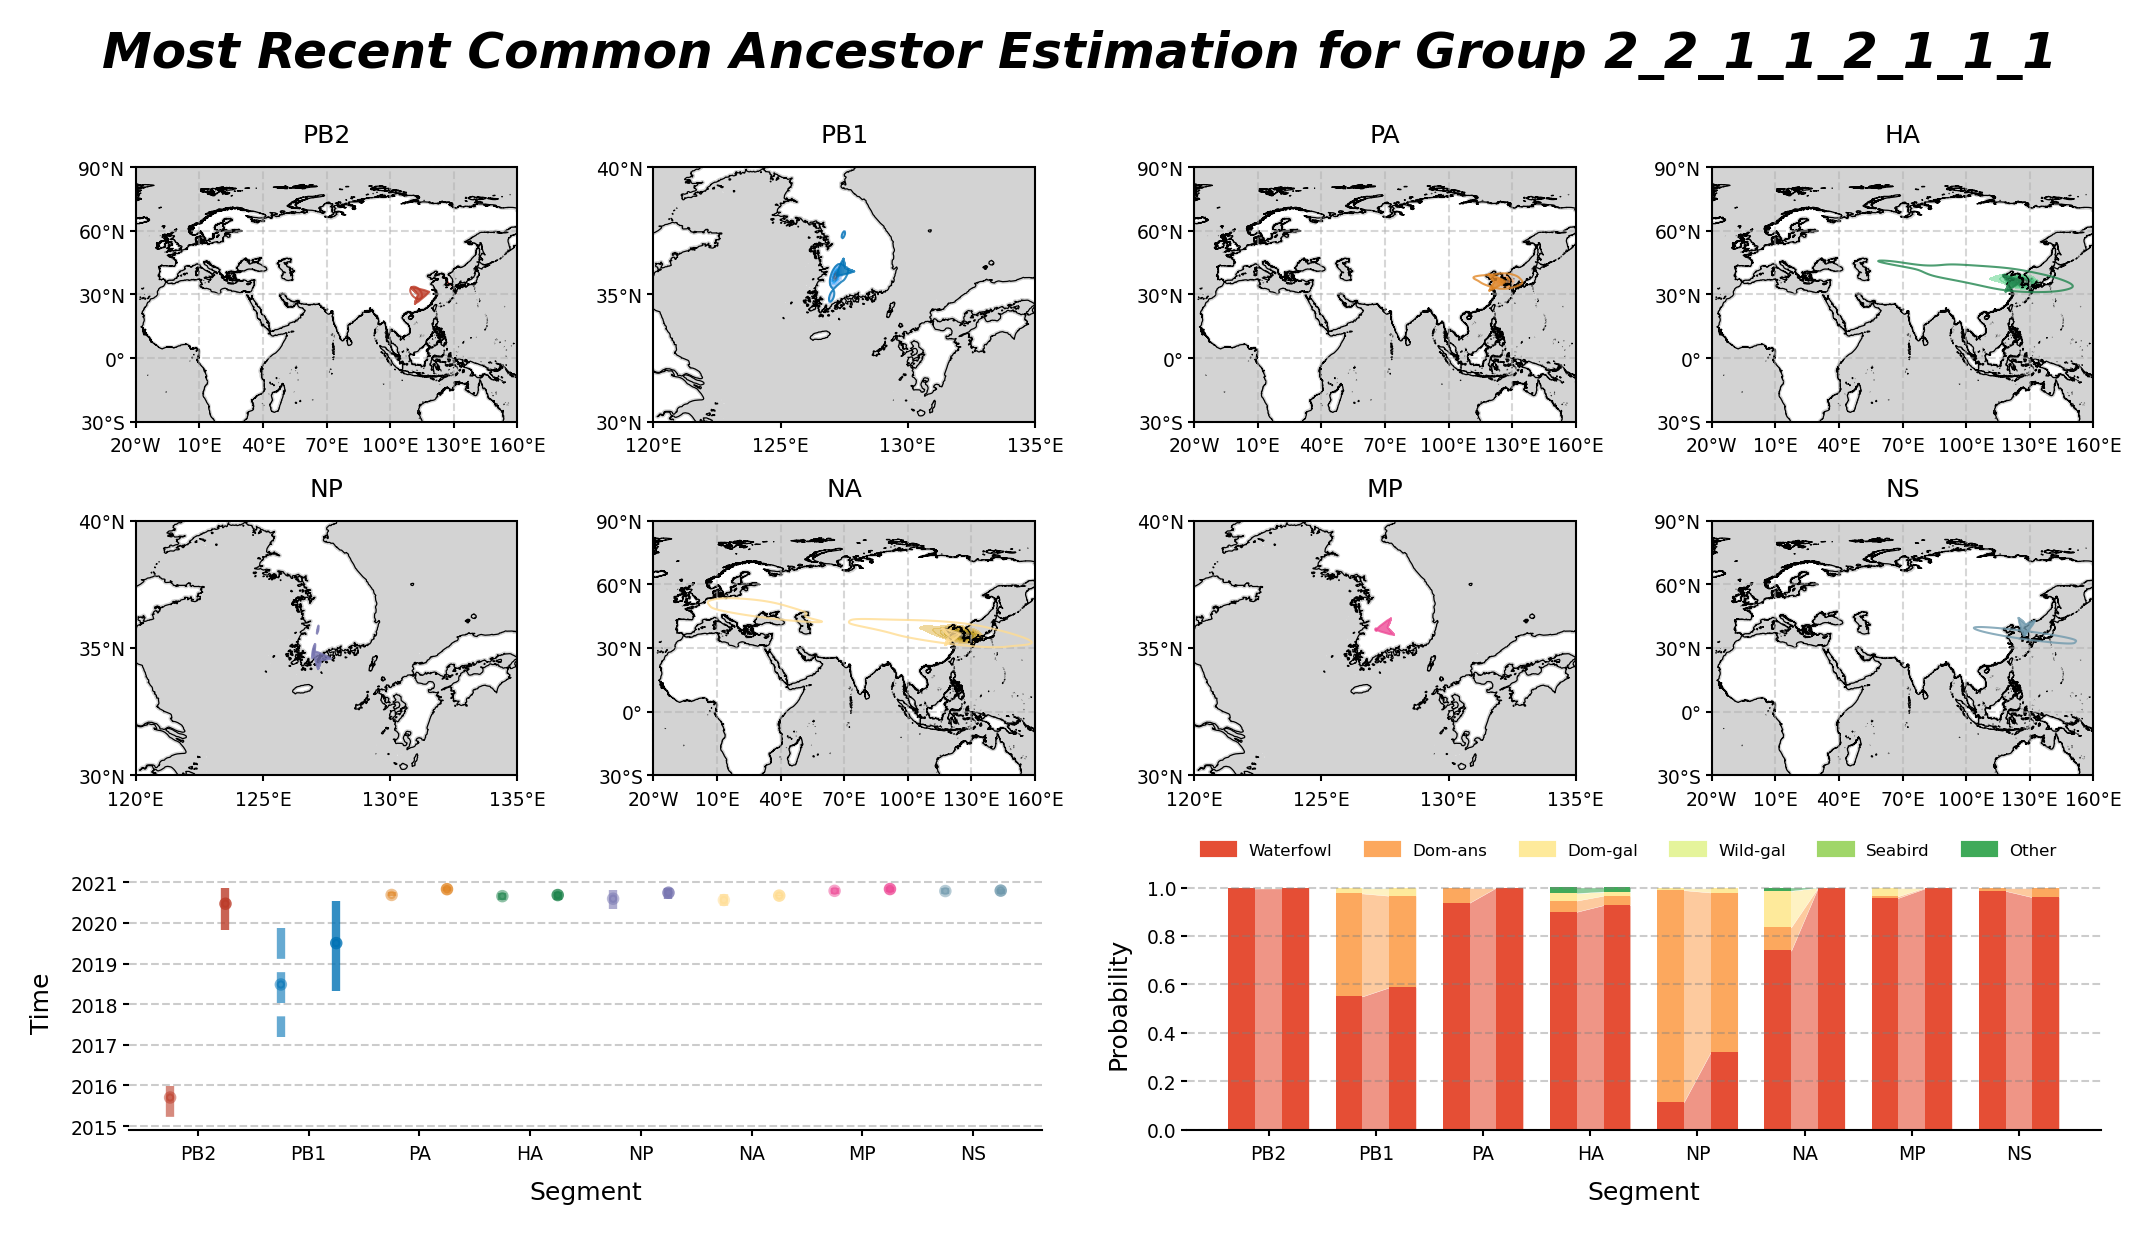

In [60]:
group = domain_group[3]

loc_dict3 = {}
for seg in seg_l:
    acc_in_group = genotype.query('group == @group').index.to_list()
    dir_group = group.replace('_', '')
    loc_dict3[seg] = [extractPosteriorTrees(acc_in_group, f'./data/03_beast_analysis/group{dir_group}/extractions{seg}/tree{i}.jtree') for i in range(1, 301)]

fig3 = plt.figure(constrained_layout=True, figsize=(7.08, 4))
gs = fig3.add_gridspec(3, 4)
proj = ccrs.PlateCarree()

f3_ax1 = fig3.add_subplot(gs[0, 0], projection=proj)
draw_single_seg_map(f3_ax1, 'PB2', loc_dict3['PB2'], color_seg[0])

f3_ax2 = fig3.add_subplot(gs[0, 1], projection=proj)
draw_single_seg_map(f3_ax2, 'PB1', loc_dict3['PB1'], color_seg[1], extent=(120, 135, 30, 40), step=(5, 5))

f3_ax3 = fig3.add_subplot(gs[0, 2], projection=proj)
draw_single_seg_map(f3_ax3, 'PA', loc_dict3['PA'], color_seg[2])

f3_ax4 = fig3.add_subplot(gs[0, 3], projection=proj)
draw_single_seg_map(f3_ax4, 'HA', loc_dict3['HA'], color_seg[3])

f3_ax5 = fig3.add_subplot(gs[1, 0], projection=proj)
draw_single_seg_map(f3_ax5, 'NP', loc_dict3['NP'], color_seg[4], extent=(120, 135, 30, 40), step=(5, 5))

f3_ax6 = fig3.add_subplot(gs[1, 1], projection=proj)
draw_single_seg_map(f3_ax6, 'NA', loc_dict3['NA'], color_seg[5])

f3_ax7 = fig3.add_subplot(gs[1, 2], projection=proj)
draw_single_seg_map(f3_ax7, 'MP', loc_dict3['MP'], color_seg[6], extent=(120, 135, 30, 40), step=(5, 5))

f3_ax8 = fig3.add_subplot(gs[1, 3], projection=proj)
draw_single_seg_map(f3_ax8, 'NS', loc_dict3['NS'], color_seg[7])

f3_ax9 = fig3.add_subplot(gs[2, 0:2])
draw_ancestor_time(f3_ax9, group, anster_est3)

f3_ax10 = fig3.add_subplot(gs[2, 2:4])
draw_ancestor_host(f3_ax10, group, anster_est3)

fig3.suptitle(f'Most Recent Common Ancestor Estimation for Group {group}', style='italic', weight='bold')
plt.show()

In [61]:
group = domain_group[4]
print(group)
df_l = []
for seg in seg_l:
    dir_group = group.replace('_', '')
    path = f'/home/zeng/DulabWork/H5N8_evolution/data_201910_202108/data/03_beast_analysis/group{dir_group}/ext_{beast_map[group][seg]}_{seg}.mcc.jtree'
    acc_in_group = genotype.query('group == @group').index.to_list()
    acc_in_group.extend(['EPI_ISL_985190', 'EPI_ISL_985189', 'EPI_ISL_1009706'])
    t = pd.DataFrame(extractMccTree(path, acc_in_group), columns=['height_m', 'height_l', 'height_u', 'Waterfowl', 'Dom-ans', 'Dom-gal', 'Wild-gal', 'Seabird', 'Other'], index=[[seg, seg], ['mrca', 'mrcga']])
    df_l.append(t)

anster_est4 = pd.concat(df_l).unstack(1).reindex(seg_l)

anster_est4

3_2_2_1_2_1_1_2


height_m              height_l              height_u             \
          mrca      mrcga       mrca      mrcga       mrca      mrcga   
PB2 2020-06-29 2019-07-08 2020-11-15 2019-09-20 2019-12-28 2019-02-23   
PB1 2019-05-21 2018-06-27 2020-06-05 2019-11-19 2018-02-17 2017-03-10   
PA  2019-05-15 2017-03-11 2020-04-13 2019-01-17 2018-04-15 2015-06-25   
HA  2020-08-29 2020-07-31 2020-09-29 2020-09-20 2020-07-28 2020-06-09   
NP  2020-02-06 2019-05-27 2020-07-30 2019-10-14 2019-08-25 2018-11-30   
NA  2020-09-20 2020-09-10 2020-09-20 2020-09-10 2020-09-20 2020-09-10   
MP  2020-08-22 2020-06-19 2020-10-07 2020-09-05 2020-06-26 2020-04-13   
NS  2018-06-24 2017-03-26 2019-11-14 2017-10-27 2017-02-25 2016-07-29   

    Waterfowl         Dom-ans         Dom-gal         Wild-gal          \
         mrca   mrcga    mrca   mrcga    mrca   mrcga     mrca   mrcga   
PB2     0.033  0.1178  0.9272  0.8592  0.0360  0.0176   0.0023  0.0038   
PB1    0.5517  0.5508  0.4203  0.4248  0.0274  0.0216   0.0003  0.0013   
PA     0.0071  0.0101  0.8680  0.8811  0.1244  0.1065   0.0001  0.0016   
HA        0.9  0.8533  0.0462  0.0500  0.0308  0.0333   0.0000  0.0000   
NP     0.2189  0.8454  0.7439  0.1478  0.0188  0.0023   0.0013  0.0011   
NA          1       1  0.0000  0.0000  0.0000  0.0000   0.0000  0.0000   
MP     0.7037    0.35  0.0222  0.0567  0.2704  0.5767   0.0000  0.0000   
NS     0.9087  0.9994  0.0834  0.0006  0.0069  0.0000   0.0006  0.0000   

    Seabird           Other          
       mrca   mrcga    mrca   mrcga  
PB2  0.0008  0.0000  0.0007  0.0007  
PB1  0.0000  0.0001  0.0002  0.0013  
PA   0.0002  0.0004  0.0001  0.0002  
HA   0.0000  0.0000  0.0231  0.0633  
NP   0.0002  0.0000  0.0167  0.0034  
NA   0.0000  0.0000  0.0000  0.0000  
MP   0.0000  0.0000  0.0037  0.0167  
NS   0.0001  0.0000  0.0002  0.0000

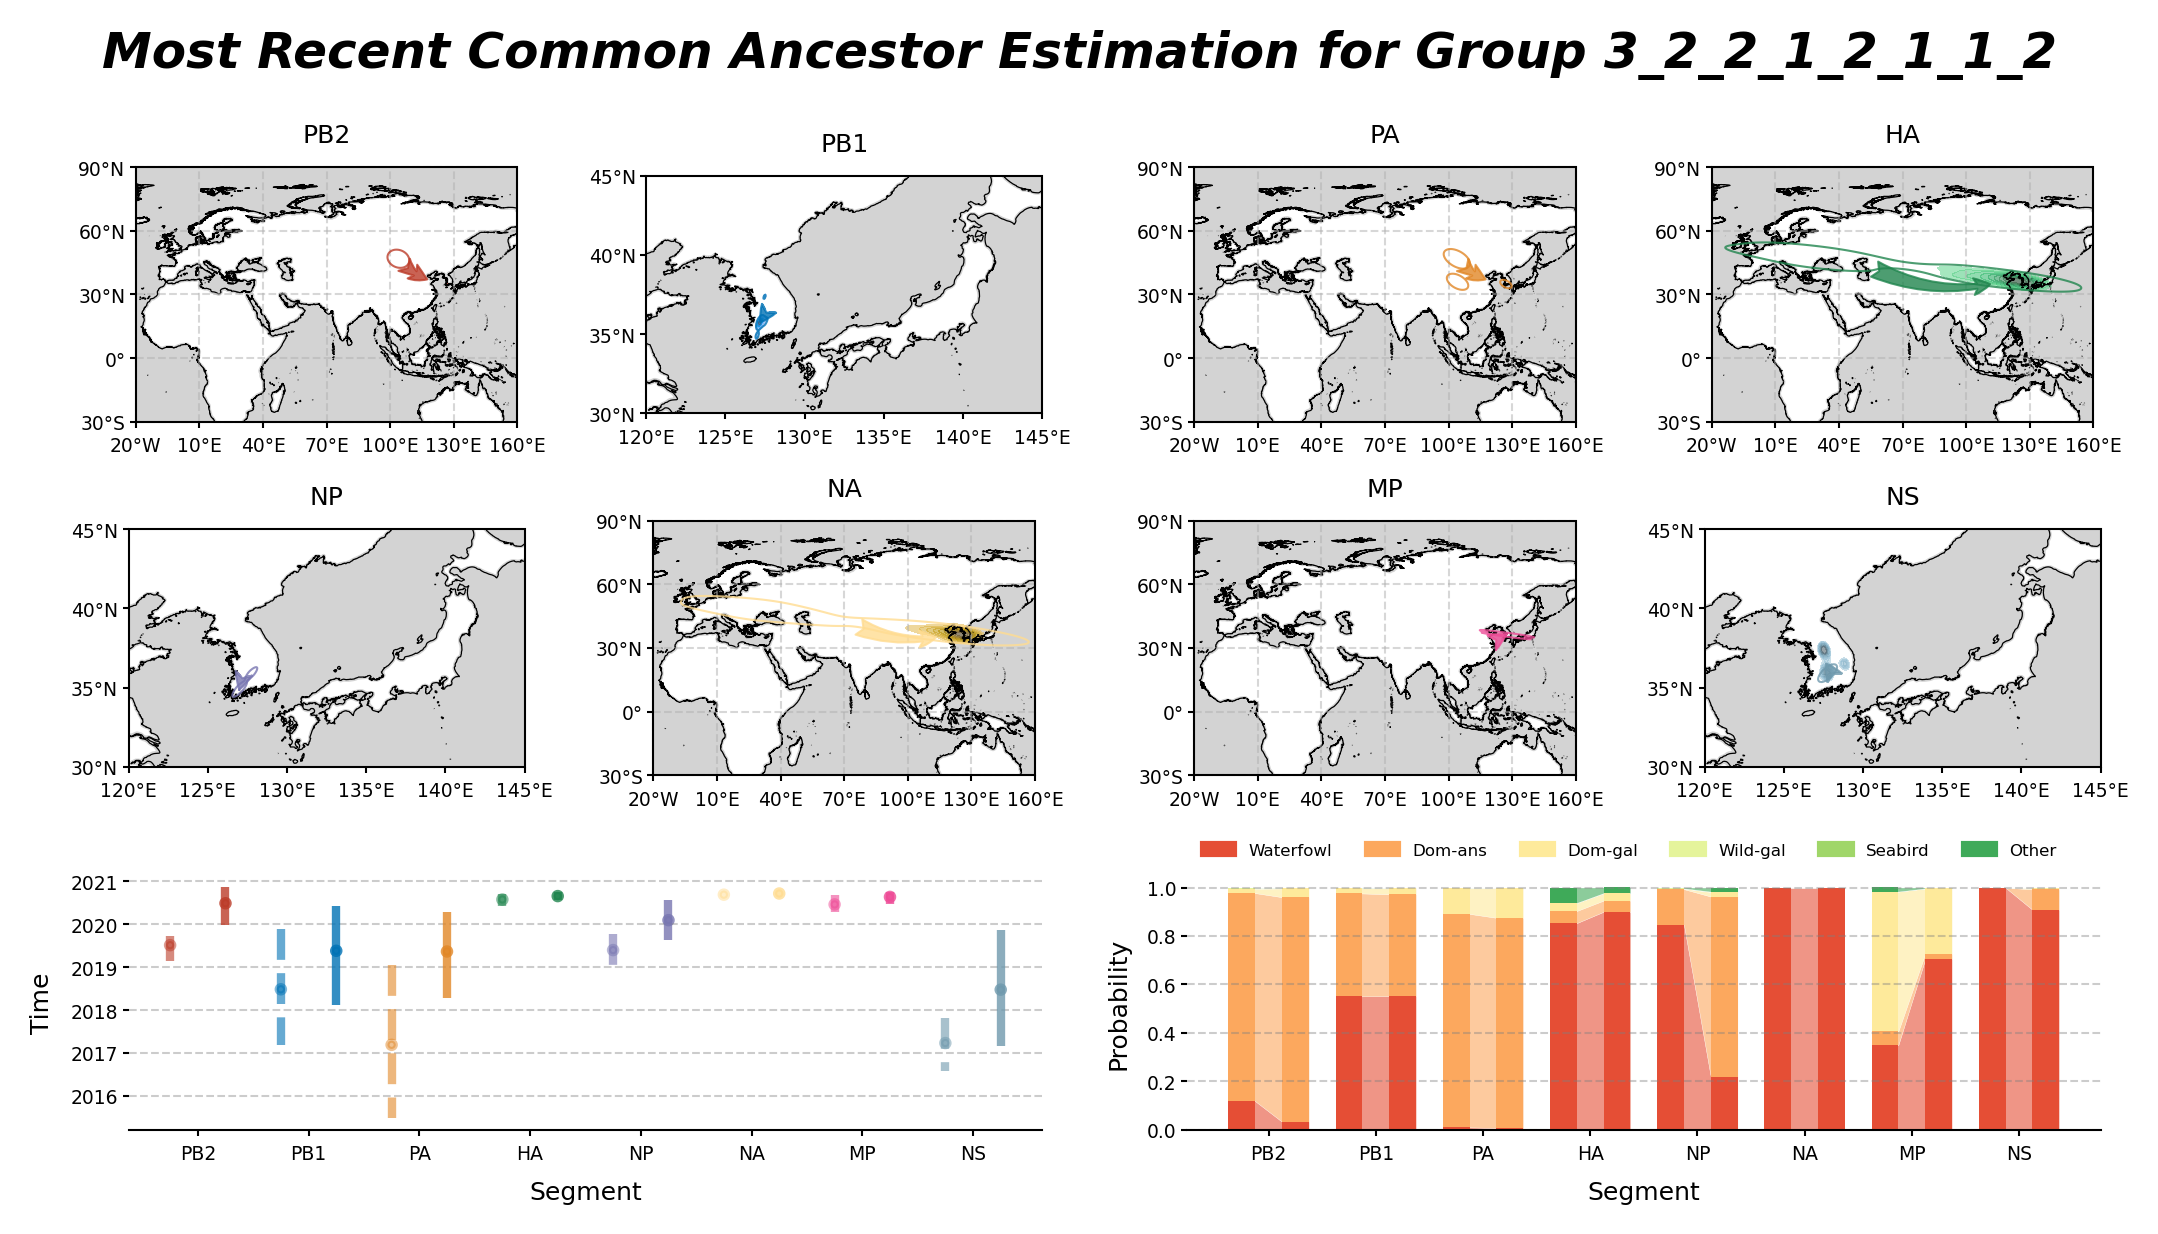

In [62]:
import matplotlib.gridspec as gridspec

loc_dict4 = {}
for seg in seg_l:
    acc_in_group = genotype.query('group == @group').index.to_list()
    acc_in_group.extend(['EPI_ISL_985190', 'EPI_ISL_985189', 'EPI_ISL_1009706'])
    dir_group = group.replace('_', '')
    loc_dict4[seg] = [extractPosteriorTrees(acc_in_group, f'./data/03_beast_analysis/group{dir_group}/extractions{seg}/tree{i}.jtree') for i in range(1, 301)]

fig3 = plt.figure(constrained_layout=True, figsize=(7.08, 4))
gs = fig3.add_gridspec(3, 4)
proj = ccrs.PlateCarree()

f3_ax1 = fig3.add_subplot(gs[0, 0], projection=proj)
draw_single_seg_map(f3_ax1, 'PB2', loc_dict4['PB2'], color_seg[0])

f3_ax2 = fig3.add_subplot(gs[0, 1], projection=proj)
draw_single_seg_map(f3_ax2, 'PB1', loc_dict4['PB1'], color_seg[1], extent=(120, 145, 30, 45), step=(5, 5))

f3_ax3 = fig3.add_subplot(gs[0, 2], projection=proj)
draw_single_seg_map(f3_ax3, 'PA', loc_dict4['PA'], color_seg[2])

f3_ax4 = fig3.add_subplot(gs[0, 3], projection=proj)
draw_single_seg_map(f3_ax4, 'HA', loc_dict4['HA'], color_seg[3])

f3_ax5 = fig3.add_subplot(gs[1, 0], projection=proj)
draw_single_seg_map(f3_ax5, 'NP', loc_dict4['NP'], color_seg[4], extent=(120, 145, 30, 45), step=(5, 5))

f3_ax6 = fig3.add_subplot(gs[1, 1], projection=proj)
draw_single_seg_map(f3_ax6, 'NA', loc_dict4['NA'], color_seg[5])

f3_ax7 = fig3.add_subplot(gs[1, 2], projection=proj)
draw_single_seg_map(f3_ax7, 'MP', loc_dict4['MP'], color_seg[6])

f3_ax8 = fig3.add_subplot(gs[1, 3], projection=proj)
draw_single_seg_map(f3_ax8, 'NS', loc_dict4['NS'], color_seg[7], extent=(120, 145, 30, 45), step=(5, 5))

f3_ax9 = fig3.add_subplot(gs[2, 0:2])
draw_ancestor_time(f3_ax9, group, anster_est4)

f3_ax10 = fig3.add_subplot(gs[2, 2:4])
draw_ancestor_host(f3_ax10, group, anster_est4)

fig3.suptitle(f'Most Recent Common Ancestor Estimation for Group {group}', style='italic', weight='bold')
plt.show()

In [63]:
group = domain_group[5]
df_l = []
for seg in seg_l:
    dir_group = group.replace('_', '')
    path = f'/home/zeng/DulabWork/H5N8_evolution/data_201910_202108/data/03_beast_analysis/group{dir_group}/ext_{beast_map[group][seg]}_{seg}.mcc.jtree'
    if (group == domain_group[5]) and (seg == 'MP'):
        acc_in_group = ['EPI_ISL_985179']
    else:
        acc_in_group = genotype.query('group == @group').index.to_list()
    t = pd.DataFrame(extractMccTree(path, acc_in_group), columns=['height_m', 'height_l', 'height_u', 'Waterfowl', 'Dom-ans', 'Dom-gal', 'Wild-gal', 'Seabird', 'Other'], index=[[seg, seg], ['mrca', 'mrcga']])
    df_l.append(t)

anster_est5 = pd.concat(df_l).unstack(1).reindex(seg_l)
anster_est5

height_m              height_l              height_u             \
          mrca      mrcga       mrca      mrcga       mrca      mrcga   
PB2 2020-11-26 2020-10-31 2020-12-16 2020-11-19 2020-11-05 2020-10-05   
PB1 2020-10-18 2020-06-16 2020-12-06 2020-08-16 2020-08-13 2020-04-12   
PA  2020-11-04 2020-10-09 2020-12-05 2020-10-21 2020-09-21 2020-09-22   
HA  2020-12-06 2020-11-27 2020-12-22 2020-12-04 2020-11-22 2020-11-17   
NP  2020-10-18 2020-08-18 2020-12-17 2020-11-13 2020-07-27 2020-05-15   
NA  2020-12-06 2020-11-21 2020-12-19 2020-11-28 2020-11-23 2020-11-06   
MP  2020-11-12 2020-10-16 2020-11-26 2020-11-11 2020-10-22 2020-09-15   
NS  2020-10-14 2020-09-12 2020-11-06 2020-10-15 2020-09-21 2020-08-06   

    Waterfowl         Dom-ans         Dom-gal         Wild-gal       Seabird  \
         mrca   mrcga    mrca   mrcga    mrca   mrcga     mrca mrcga    mrca   
PB2    0.0367  0.0753  0.9633  0.9247  0.0000  0.0000        0     0       0   
PB1    0.0067     0.2  0.9700  0.5467  0.0233  0.2500        0     0       0   
PA     0.3221       1  0.6745  0.0000  0.0034  0.0000        0     0       0   
HA     0.0941  0.2083  0.8824  0.7917  0.0235  0.0000        0     0       0   
NP     0.0088  0.0559  0.9894  0.9235  0.0018  0.0206        0     0       0   
NA     0.1133  0.9655  0.8867  0.0345  0.0000  0.0000        0     0       0   
MP     0.0513  0.9574  0.9402  0.0071  0.0085  0.0355        0     0       0   
NS     0.9861   0.717  0.0139  0.0472  0.0000  0.2358        0     0       0   

          Other          
    mrcga  mrca   mrcga  
PB2     0   0.0  0.0000  
PB1     0   0.0  0.0033  
PA      0   0.0  0.0000  
HA      0   0.0  0.0000  
NP      0   0.0  0.0000  
NA      0   0.0  0.0000  
MP      0   0.0  0.0000  
NS      0   0.0  0.0000

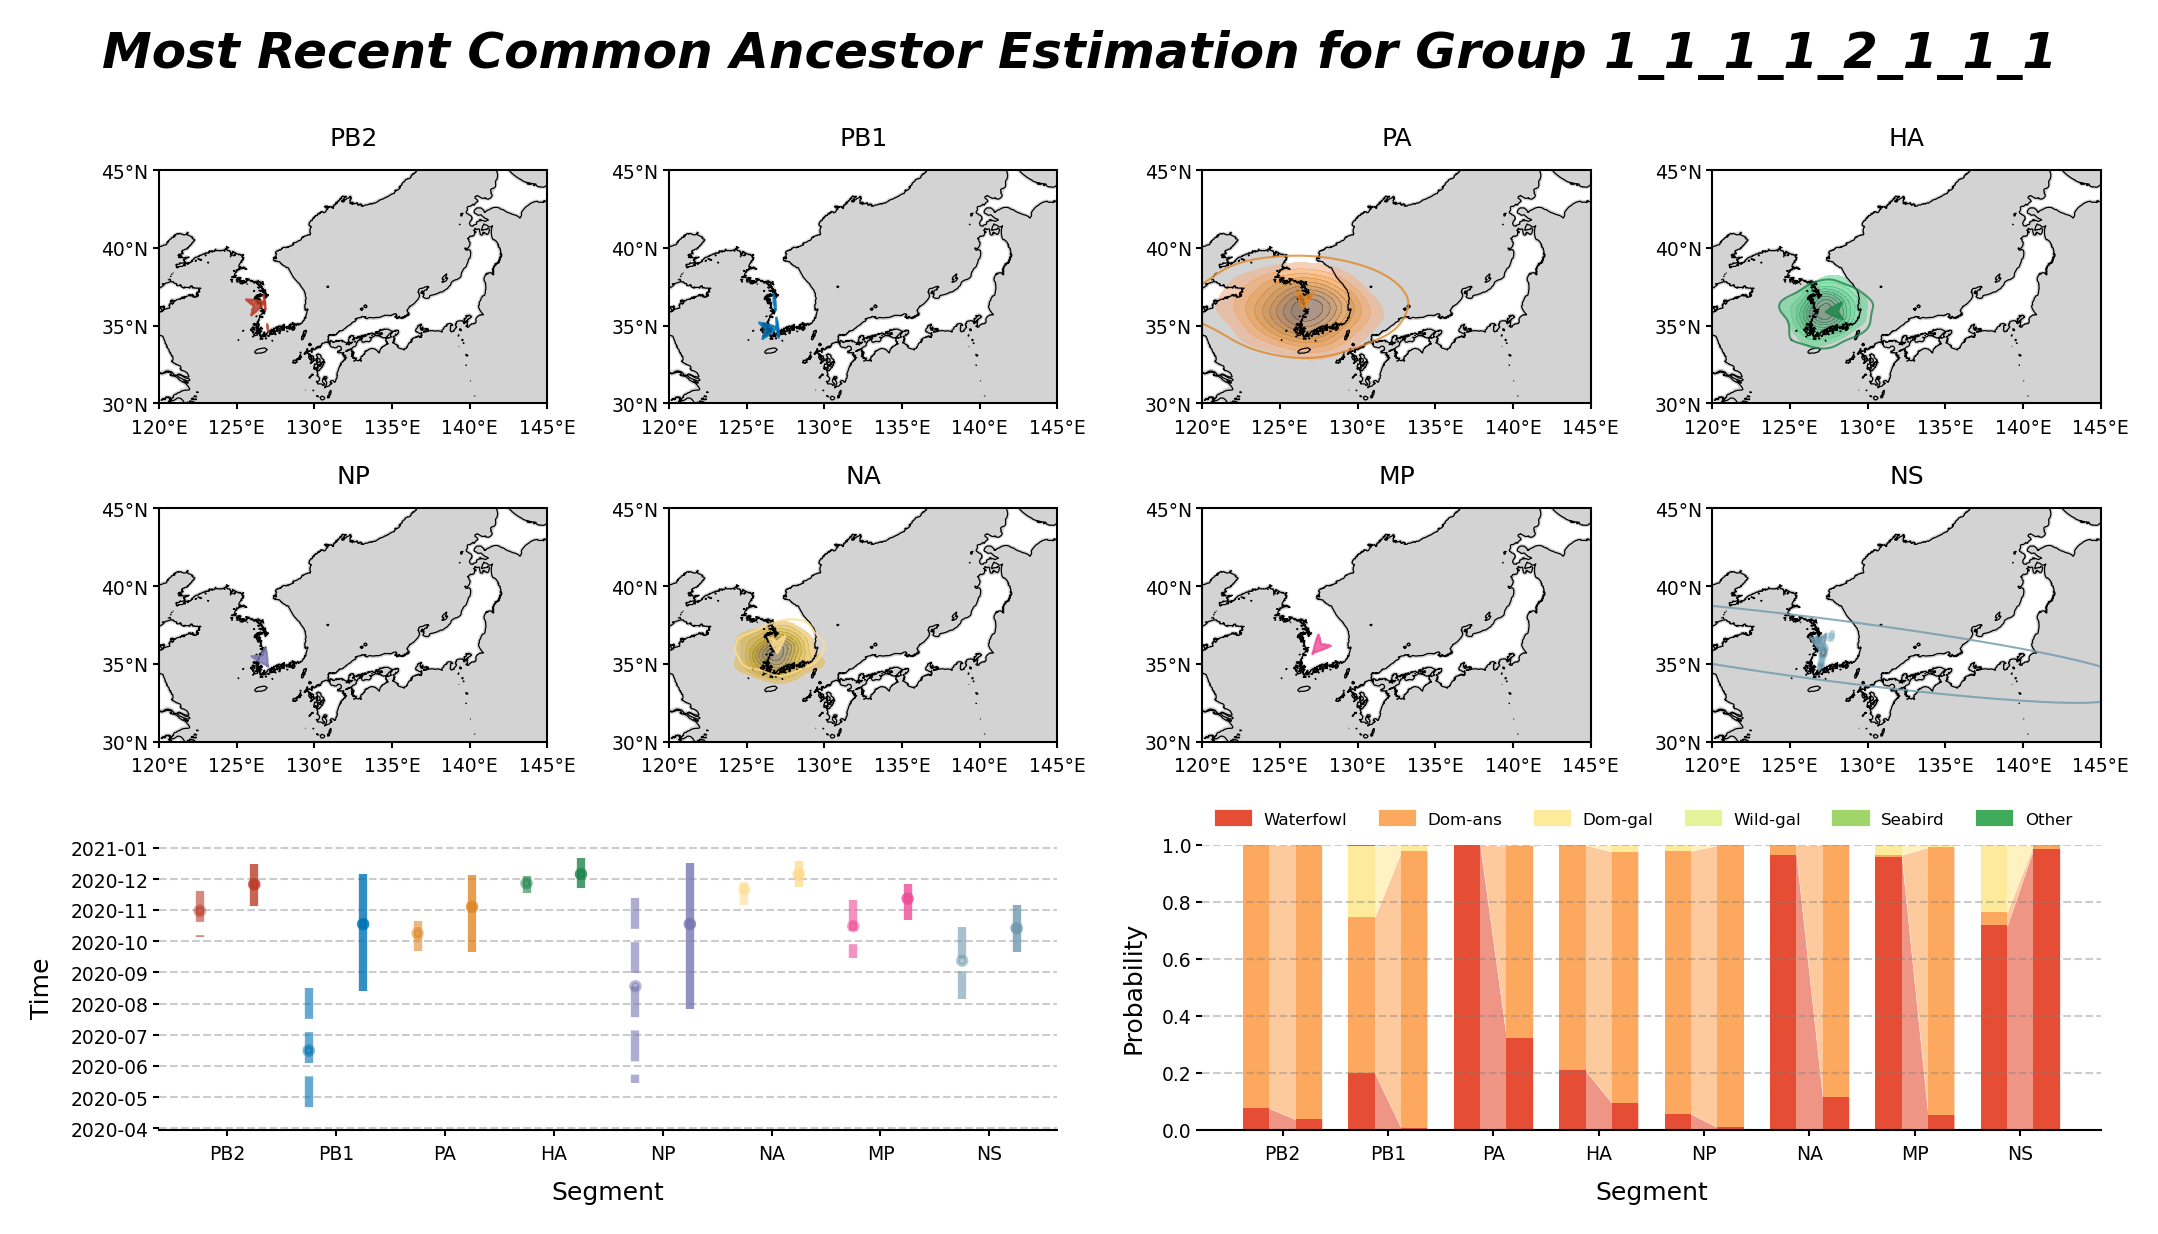

In [64]:
import matplotlib.gridspec as gridspec


loc_dict5 = {}
for seg in seg_l:
    if (group == domain_group[5]) and (seg == 'MP'):
        acc_in_group = ['EPI_ISL_985179']
    else:
        acc_in_group = genotype.query('group == @group').index.to_list()
    loc_dict5[seg] = [extractPosteriorTrees(acc_in_group, f'./data/03_beast_analysis/group{dir_group}/extractions{seg}/tree{i}.jtree') for i in range(1, 301)]

fig3 = plt.figure(constrained_layout=True, figsize=(7.08, 4))
gs = fig3.add_gridspec(3, 4)
proj = ccrs.PlateCarree()

f3_ax1 = fig3.add_subplot(gs[0, 0], projection=proj)
draw_single_seg_map(f3_ax1, 'PB2', loc_dict5['PB2'], color_seg[0], extent=(120, 145, 30, 45), step=(5, 5))

f3_ax2 = fig3.add_subplot(gs[0, 1], projection=proj)
draw_single_seg_map(f3_ax2, 'PB1', loc_dict5['PB1'], color_seg[1], extent=(120, 145, 30, 45), step=(5, 5))

f3_ax3 = fig3.add_subplot(gs[0, 2], projection=proj)
draw_single_seg_map(f3_ax3, 'PA', loc_dict5['PA'], color_seg[2], extent=(120, 145, 30, 45), step=(5, 5))

f3_ax4 = fig3.add_subplot(gs[0, 3], projection=proj)
draw_single_seg_map(f3_ax4, 'HA', loc_dict5['HA'], color_seg[3], extent=(120, 145, 30, 45), step=(5, 5))

f3_ax5 = fig3.add_subplot(gs[1, 0], projection=proj)
draw_single_seg_map(f3_ax5, 'NP', loc_dict5['NP'], color_seg[4], extent=(120, 145, 30, 45), step=(5, 5))

f3_ax6 = fig3.add_subplot(gs[1, 1], projection=proj)
draw_single_seg_map(f3_ax6, 'NA', loc_dict5['NA'], color_seg[5], extent=(120, 145, 30, 45), step=(5, 5))

f3_ax7 = fig3.add_subplot(gs[1, 2], projection=proj)
draw_single_seg_map(f3_ax7, 'MP', loc_dict5['MP'], color_seg[6], extent=(120, 145, 30, 45), step=(5, 5))

f3_ax8 = fig3.add_subplot(gs[1, 3], projection=proj)
draw_single_seg_map(f3_ax8, 'NS', loc_dict5['NS'], color_seg[7], extent=(120, 145, 30, 45), step=(5, 5))

f3_ax9 = fig3.add_subplot(gs[2, 0:2])
draw_ancestor_time(f3_ax9, group, anster_est5)

f3_ax10 = fig3.add_subplot(gs[2, 2:4])
draw_ancestor_host(f3_ax10, group, anster_est5)

fig3.suptitle(f'Most Recent Common Ancestor Estimation for Group {group}', style='italic', weight='bold')
plt.show()

In [86]:
group = domain_group[2]
print(group)
df_l = []
for seg in seg_l:
    dir_group = group.replace('_', '')
    path = f'/home/zeng/DulabWork/H5N8_evolution/data_201910_202108/data/03_beast_analysis/group{dir_group}/ext_{beast_map[group][seg]}_{seg}.mcc.jtree'
    acc_in_group = genotype.query('group == @group').index.to_list()
    t = pd.DataFrame(extractMccTree(path, acc_in_group), columns=['height_m', 'height_l', 'height_u', 'Waterfowl', 'Dom-ans', 'Dom-gal', 'Wild-gal', 'Seabird', 'Other'], index=[[seg, seg], ['mrca', 'mrcga']])
    df_l.append(t)

anster_est2 = pd.concat(df_l).unstack(1).reindex(seg_l)
anster_est2

4_2_3_0_3_2_0_0


height_m              height_l              height_u             \
          mrca      mrcga       mrca      mrcga       mrca      mrcga   
PB2 2020-08-12 2016-11-05 2020-09-20 2017-06-09 2020-04-19 2015-12-24   
PB1 2020-09-16 2016-09-13 2020-09-20 2016-12-15 2020-09-01 2016-05-22   
PA  2020-08-20 2018-07-30 2020-09-18 2019-10-21 2020-06-30 2017-04-05   
HA  2020-07-31 2020-07-01 2020-09-09 2020-08-22 2020-05-15 2020-05-06   
NP  2020-09-16 2019-05-21 2020-09-19 2020-01-07 2020-09-01 2018-10-02   
NA  2020-09-20 2018-10-03 2020-09-20 2018-10-05 2020-09-19 2018-10-01   
MP  2020-09-06 2020-08-30 2020-09-06 2020-08-30 2020-09-06 2020-08-30   
NS  2020-08-27 2020-05-03 2020-09-19 2020-07-13 2020-07-28 2020-03-17   

    Waterfowl         Dom-ans         Dom-gal         Wild-gal          \
         mrca   mrcga    mrca   mrcga    mrca   mrcga     mrca   mrcga   
PB2    0.0011  0.9996  0.0000  0.0000  0.9989  0.0004      0.0  0.0000   
PB1    0.0000  0.3682  0.0000  0.4662  0.9999  0.0665      0.0  0.0036   
PA     0.0004  0.9335  0.0000  0.0004  0.9996  0.0642      0.0  0.0002   
HA     0.0764  0.2723  0.0121  0.0161  0.9115  0.7104      0.0  0.0000   
NP     0.0001  0.9688  0.0000  0.0004  0.9999  0.0288      0.0  0.0001   
NA     0.0000  0.9520  0.0000  0.0397       1  0.0022      0.0  0.0006   
MP     0.0000  0.0000  0.0000  0.0000       1       1      0.0  0.0000   
NS     0.0183  0.2647  0.0004  0.0000  0.9812  0.7353      0.0  0.0000   

    Seabird         Other          
       mrca   mrcga  mrca   mrcga  
PB2     0.0  0.0000   0.0  0.0000  
PB1     0.0  0.0689   0.0  0.0244  
PA      0.0  0.0002   0.0  0.0013  
HA      0.0  0.0000   0.0  0.0012  
NP      0.0  0.0004   0.0  0.0014  
NA      0.0  0.0001   0.0  0.0053  
MP      0.0  0.0000   0.0  0.0000  
NS      0.0  0.0000   0.0  0.0000

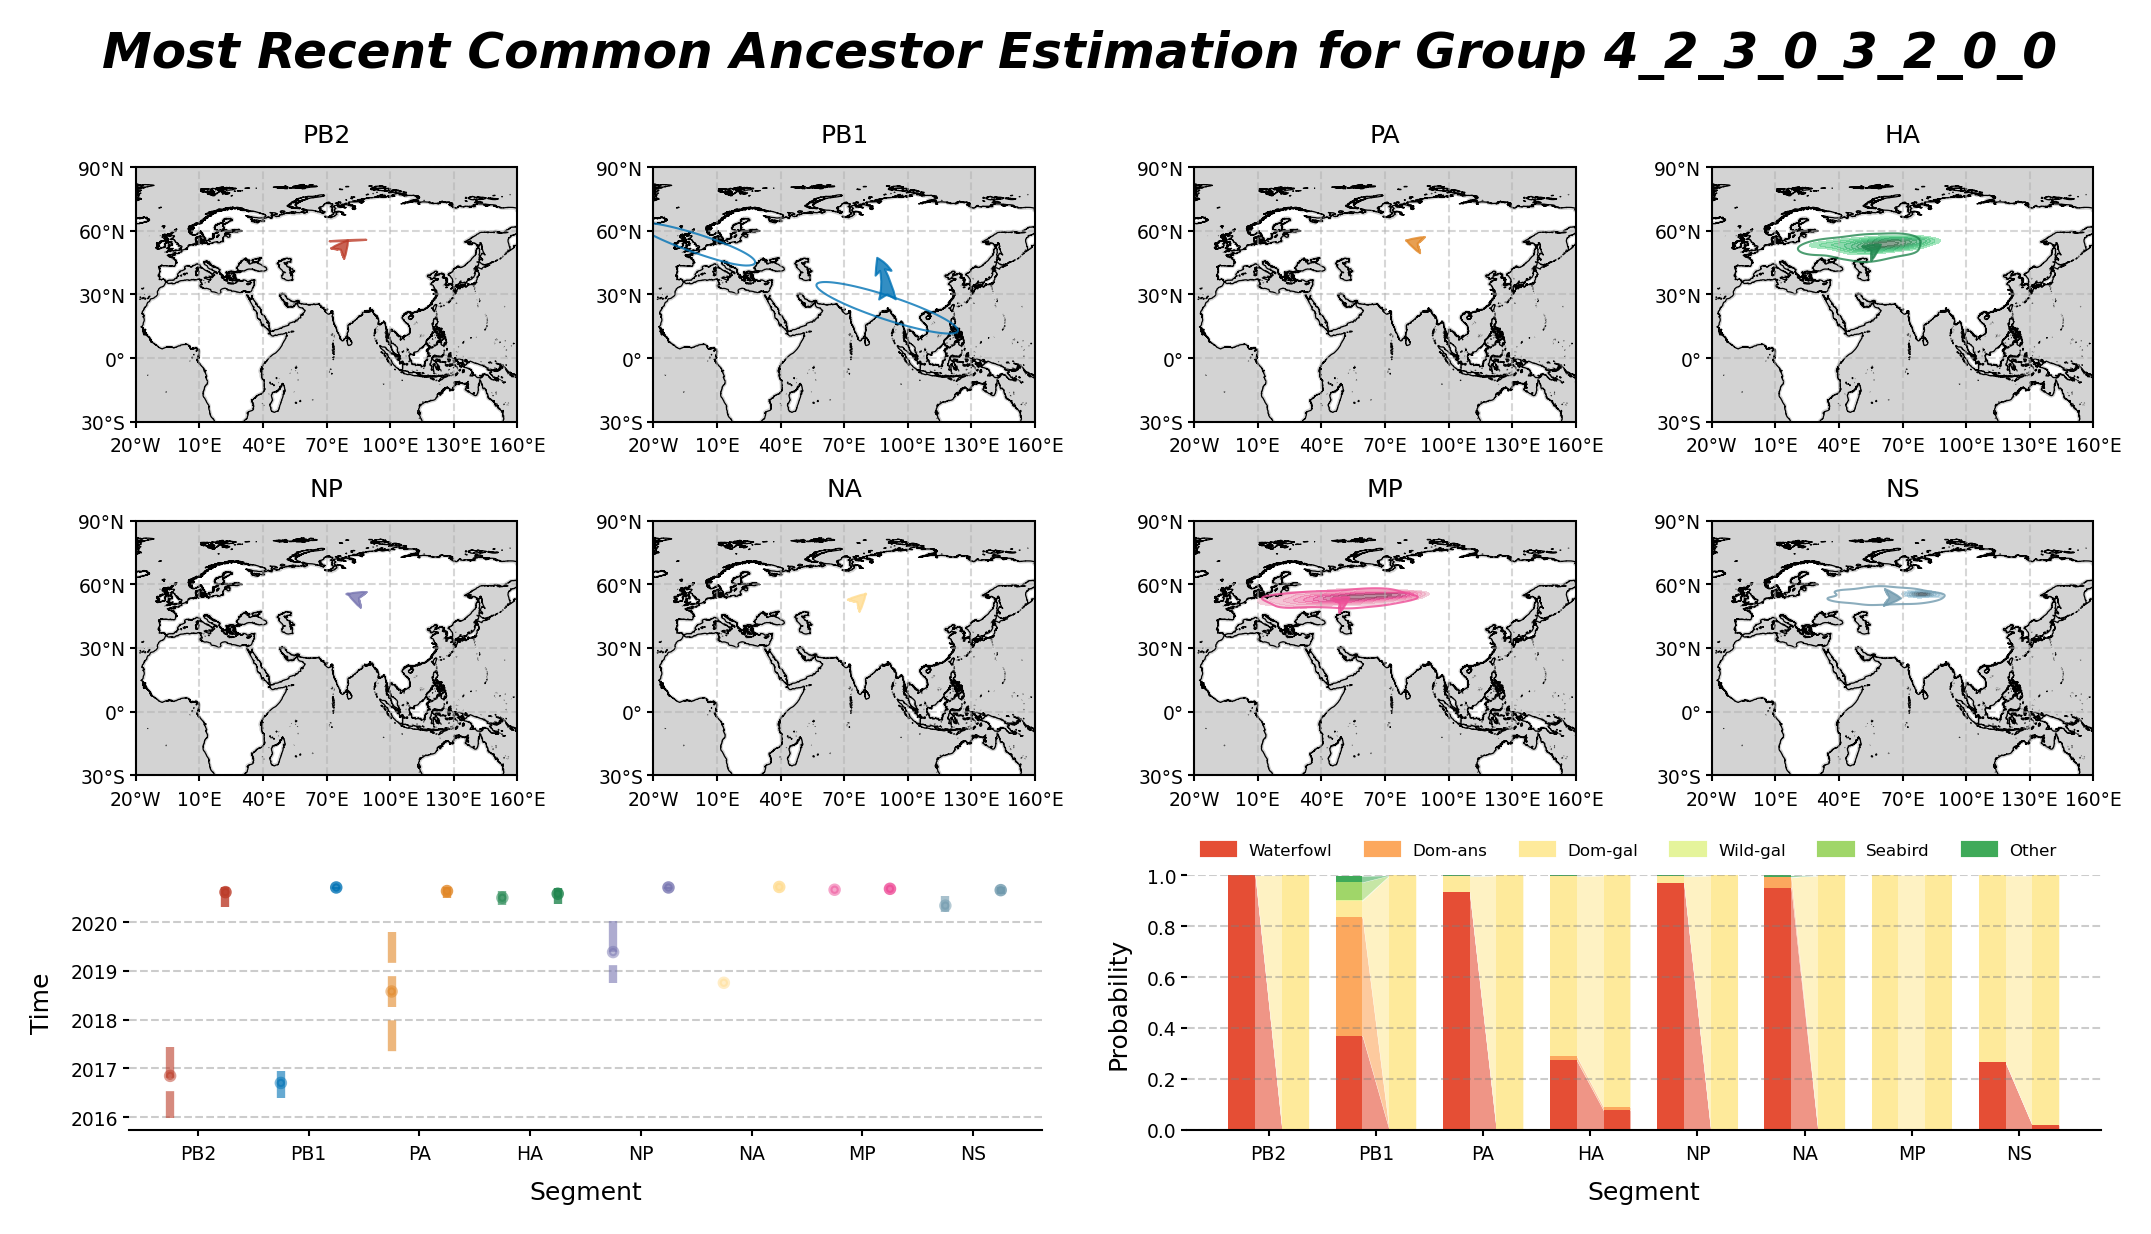

In [87]:
import matplotlib.gridspec as gridspec


loc_dict6 = {}
for seg in seg_l:
    acc_in_group = genotype.query('group == @group').index.to_list()
    dir_group = group.replace('_', '')
    loc_dict6[seg] = [extractPosteriorTrees(acc_in_group, f'./data/03_beast_analysis/group{dir_group}/extractions{seg}/tree{i}.jtree') for i in range(1, 301)]
    
fig3 = plt.figure(constrained_layout=True, figsize=(7.08, 4))
gs = fig3.add_gridspec(3, 4)
proj = ccrs.PlateCarree()

f3_ax1 = fig3.add_subplot(gs[0, 0], projection=proj)
draw_single_seg_map(f3_ax1, 'PB2', loc_dict6['PB2'], color_seg[0])

f3_ax2 = fig3.add_subplot(gs[0, 1], projection=proj)
draw_single_seg_map(f3_ax2, 'PB1', loc_dict6['PB1'], color_seg[1])

f3_ax3 = fig3.add_subplot(gs[0, 2], projection=proj)
draw_single_seg_map(f3_ax3, 'PA', loc_dict6['PA'], color_seg[2])

f3_ax4 = fig3.add_subplot(gs[0, 3], projection=proj)
draw_single_seg_map(f3_ax4, 'HA', loc_dict6['HA'], color_seg[3])

f3_ax5 = fig3.add_subplot(gs[1, 0], projection=proj)
draw_single_seg_map(f3_ax5, 'NP', loc_dict6['NP'], color_seg[4])

f3_ax6 = fig3.add_subplot(gs[1, 1], projection=proj)
draw_single_seg_map(f3_ax6, 'NA', loc_dict6['NA'], color_seg[5])

f3_ax7 = fig3.add_subplot(gs[1, 2], projection=proj)
draw_single_seg_map(f3_ax7, 'MP', loc_dict6['MP'], color_seg[6])

f3_ax8 = fig3.add_subplot(gs[1, 3], projection=proj)
draw_single_seg_map(f3_ax8, 'NS', loc_dict6['NS'], color_seg[7])

f3_ax9 = fig3.add_subplot(gs[2, 0:2])
draw_ancestor_time(f3_ax9, group, anster_est2)

f3_ax10 = fig3.add_subplot(gs[2, 2:4])
draw_ancestor_host(f3_ax10, group, anster_est2)

fig3.suptitle(f'Most Recent Common Ancestor Estimation for Group {group}', style='italic', weight='bold')
plt.show()